---

<p style='text-align: center;'>DS PROJECT</p>
<h1 align="center">Credit Risk Modelling with Optbinning</h1> 
<div style="text-align: right">Created<br>
-- by Author: Kousik Naskar<br>
-- Date: 29 July 2025</div>

---

## ✅ 1. Import Libraries & Set Config

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from typing import Tuple, List
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, average_precision_score, brier_score_loss,
    roc_curve
)
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks
from sklearn.calibration import calibration_curve
from scipy.stats import ks_2samp
#import lightgbm as lgb
#import xgboost as xgb
from optbinning import BinningProcess, Scorecard

from IPython.display import display

# Plotting style
#plt.style.use("seaborn-v0_8")
#sns.set_style("darkgrid")
RANDOM_STATE = 42

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [3]:
custom_palette = ["#219ebc", "#e63946", "#023047", "#ffb703", "#8ecae6"]

## 2. Load & Inspect Data

In [4]:
def load_data(path: str) -> pd.DataFrame:
    """
    Load dataset from a CSV file.
    Args:
        path (str): Path to the dataset.
    Returns:
        pd.DataFrame: Loaded DataFrame with renamed target.
    """
    try:
        df = pd.read_csv(path).copy()
        df = df.rename(columns={"loan_status": "target"})
        return df
    except Exception as e:
        raise FileNotFoundError(f"Failed to load data: {e}")

In [5]:
path = "../data/raw/credit_risk_dataset.csv"
df = load_data(path)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.734600,6.348078,20.00,23.00,26.00,30.00,144.00
person_income,32581.0,66074.848470,61983.119168,4000.00,38500.00,55000.00,79200.00,6000000.00
person_emp_length,31686.0,4.789686,4.142630,0.00,2.00,4.00,7.00,123.00
loan_amnt,32581.0,9589.371106,6322.086646,500.00,5000.00,8000.00,12200.00,35000.00
loan_int_rate,29465.0,11.011695,3.240459,5.42,7.90,10.99,13.47,23.22
target,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.170203,0.106782,0.00,0.09,0.15,0.23,0.83
cb_person_cred_hist_length,32581.0,5.804211,4.055001,2.00,3.00,4.00,8.00,30.00


## 3. Outlier Capping

In [6]:
def cap_outliers(df: pd.DataFrame, lower_q: float = 0.01, upper_q: float = 0.99) -> pd.DataFrame:
    """
    Clip numeric features at 1st and 99th percentiles.
    Args:
        df (pd.DataFrame): Input DataFrame.
        lower_q (float): Lower quantile for flooring.
        upper_q (float): Upper quantile for capping.
    Returns:
        pd.DataFrame: DataFrame with outliers capped.
    """
    try:
        for col in df.select_dtypes("number").columns:
            if col != "target":
                lower = df[col].quantile(lower_q)
                upper = df[col].quantile(upper_q)
                df[col] = np.clip(df[col], lower, upper)
        return df
    except Exception as e:
        raise ValueError(f"Outlier treatment failed: {e}")

In [7]:
df = cap_outliers(df)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,32581.0,27.659894,5.916132,21.00,23.00,26.00,30.00,50.00
person_income,32581.0,64368.147970,37761.494419,14400.00,38500.00,55000.00,79200.00,225200.00
person_emp_length,31686.0,4.758663,3.934398,0.00,2.00,4.00,7.00,18.00
loan_amnt,32581.0,9556.484608,6202.355384,1000.00,5000.00,8000.00,12200.00,29800.00
loan_int_rate,29465.0,11.002340,3.215820,5.42,7.90,10.99,13.47,18.62
target,32581.0,0.218164,0.413006,0.00,0.00,0.00,0.00,1.00
loan_percent_income,32581.0,0.169740,0.104820,0.02,0.09,0.15,0.23,0.50
cb_person_cred_hist_length,32581.0,5.744514,3.817842,2.00,3.00,4.00,8.00,17.00


In [8]:
for col in df.select_dtypes("object").columns:
    if col != "loan_status":
        print(f"{col}: unique values = {df[col].unique()}")

person_home_ownership: unique values = ['RENT' 'OWN' 'MORTGAGE' 'OTHER']
loan_intent: unique values = ['PERSONAL' 'EDUCATION' 'MEDICAL' 'VENTURE' 'HOMEIMPROVEMENT'
 'DEBTCONSOLIDATION']
loan_grade: unique values = ['D' 'B' 'C' 'A' 'E' 'F' 'G']
cb_person_default_on_file: unique values = ['Y' 'N']


## 4. Stratified Splitting (Dev/Test/OOT)
### 📊 Data Splitting Strategy

In the absence of explicit time or year-based information in the dataset, we adopted a **stratified splitting** approach to mimic a real-world model validation process, including an **Out-of-Time** (OOT) evaluation.

### ✅ Purpose of This Splitting Approach

#### Mimicking Production-Like Evaluation:

- In real-world credit risk modeling, it is common to evaluate model stability over time using a hold-out set that simulates future data (OOT set).

- Since our dataset lacks a time variable, we simulate an OOT set using a **random but stratified split**, ensuring class distribution is preserved.

#### Robust Model Validation:

We split the dataset into three sets:

- Train (56%) – for model training.

- Test (24%) – for performance evaluation during development.

- OOT (20%) – simulates unseen future data for post-development validation.

This three-way split helps assess **model performance**, **generalization**, and **temporal stability**.

#### Stratified Splits to Handle Class Imbalance:

- The target variable (`loan_status`) is imbalanced. To maintain consistent distribution across all splits, we use **stratified sampling**, ensuring that the proportion of defaults (1s) and non-defaults (0s) is preserved.

#### Enables Stability Metrics (e.g., PSI):

- By having an OOT set, we can calculate **Population Stability Index (PSI)** and monitor **prediction drift** between training and future-like data.

- PSI helps assess whether the model's scoring remains stable over time or shifts due to data distribution changes.

In [9]:
def stratified_split(df: pd.DataFrame, target: str) -> Tuple:
    """
    Split data into dev/test and OOT (Out-of-time) set using stratified split..
    Args:
        df (pd.DataFrame): Full dataset.
        target (str): Target column.
    Returns:
        Tuple: Split datasets (X_train, X_test, X_oot, y_train, y_test, y_oot)
    """
    try:
        df_dev, df_oot = train_test_split(df, test_size=0.2, stratify=df[target], random_state=RANDOM_STATE)
        X_dev, y_dev = df_dev.drop(columns=target), df_dev[target]
        X_oot, y_oot = df_oot.drop(columns=target), df_oot[target]

        X_train, X_test, y_train, y_test = train_test_split(
            X_dev, y_dev, test_size=0.3, stratify=y_dev, random_state=RANDOM_STATE
        )
        return X_train, X_test, X_oot, y_train, y_test, y_oot
    except Exception as e:
        raise ValueError(f"Stratified split failed: {e}")

In [10]:
X_train, X_test, X_oot, y_train, y_test, y_oot = stratified_split(df, target="target")

# Shape of training, test and oot sets
print(f"Train  shape: {X_train.shape}, Test shape: {X_test.shape}, OOT shape: {X_oot.shape}")
print(f"======================")
print(f"Train target shape: {y_train.shape}, Test target shape: {y_test.shape}, OOT target shape: {y_oot.shape}")

Train  shape: (18244, 11), Test shape: (7820, 11), OOT shape: (6517, 11)
Train target shape: (18244,), Test target shape: (7820,), OOT target shape: (6517,)


## ✅ 5. Binning Process Setup

In [11]:
def apply_binning(X_train: pd.DataFrame, y_train: pd.Series) -> BinningProcess:
    """
    Fit and apply optbinning WOE binning.
    Args:
        X_train (pd.DataFrame): Training features.
        y_train (pd.Series): Training target.
    Returns:
        BinningProcess: Binning process.
    """
    try:
        cat_vars = X_train.select_dtypes("object").columns.tolist()
        bp = BinningProcess(variable_names=X_train.columns.tolist(), categorical_variables=cat_vars)
        bp.fit(X_train, y_train)
        return bp
    except Exception as e:
        raise ValueError(f"Binning failed: {e}")

In [12]:
# ===== Binning Process =====
bp = apply_binning(X_train, y_train)
bp

,variable_names,"['person_age', 'person_income', ...]"
,max_n_prebins,20
,min_prebin_size,0.05
,min_n_bins,None
,max_n_bins,None
,min_bin_size,None
,max_bin_size,None
,max_pvalue,None
,max_pvalue_policy,'consecutive'
,selection_criteria,None
,fixed_variables,None


In [13]:
bp.summary()

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
0,person_age,numerical,OPTIMAL,True,5,0.012128,0.001513,0.051414,0.010354
1,person_income,numerical,OPTIMAL,True,8,0.582214,0.067927,0.400231,0.387819
2,person_home_ownership,categorical,OPTIMAL,True,3,0.422021,0.051352,0.315892,0.704358
3,person_emp_length,numerical,OPTIMAL,True,8,0.077008,0.009577,0.154324,0.005345
4,loan_intent,categorical,OPTIMAL,True,6,0.096608,0.012008,0.169839,0.122781
5,loan_grade,categorical,OPTIMAL,True,4,0.839855,0.095872,0.438477,0.320241
6,loan_amnt,numerical,OPTIMAL,True,9,0.099046,0.012207,0.166049,0.239212
7,loan_int_rate,numerical,OPTIMAL,True,10,0.683056,0.078893,0.42045,0.275301
8,loan_percent_income,numerical,OPTIMAL,True,9,0.946183,0.103949,0.442001,0.002481
9,cb_person_default_on_file,categorical,OPTIMAL,True,2,0.165292,0.020254,0.16615,0.24503


## 6. Information Value & WOE Plotting

### 📌 Why Use WOE?

- **Weight of Evidence (WOE)** transforms categorical or continuous variables into a format that captures their predictive power for binary classification problems.

- WOE is calculated at the bin (bucket) level. It is calculated using the distribution of **goods (non-defaults)** and **bads (defaults)** within that bin:

    $$
    \text{WOE}_i = \ln\left( \frac{\% \text{ of Goods in Bin } i}{\% \text{ of Bads in Bin } i} \right)
    $$

- It provides:

    - **Monotonicity**: Helps models (especially logistic regression) learn linear relationships.

    - **Interpretability**: Positive WOE = higher likelihood of default; negative WOE = lower likelihood.

### 📊 Why Use IV?

- **Information Value (IV)** quantifies how predictive each variable is in separating the target classes.

- IV summarizes the total predictive power of a variable across all of its bins. It is the sum of the contributions from each bin:
    $$
    \text{IV}_{\text{variable}} = \sum_{i} \left( \left( P(\text{Good}_i) - P(\text{Bad}_i) \right) \times \text{WOE}_i \right)
    $$


- It helps with:

    - **Feature selection**: Identify which variables carry the most signal.

    - **Model diagnostics**: Detect weak or irrelevant features early.

| IV Range   | Predictive Power               |
| ---------- | ------------------------------ |
| < 0.02     | Not predictive                 |
| 0.02 – 0.1 | Weak                           |
| 0.1 – 0.3  | Medium                         |
| 0.3 – 0.5  | Strong                         |
| > 0.5      | Very Strong (possible overfit) |

In [14]:
def interpret_iv(score: float) -> str:
    """
    Interpret Information Value (IV) score into descriptive band.
    Args:
        score (float): IV score.
    Returns:
        str: Interpretation.
    """
    if score < 0.02: return "Not Predictive"
    elif score < 0.1: return "Weak"
    elif score < 0.3: return "Medium"
    elif score < 0.5: return "Strong"
    else: return "Very Strong"

def calculate_iv(bp: BinningProcess) -> pd.DataFrame:
    """
    Calculate Information Value (IV) for each feature using optbinning tables.
    Args:
        bp (BinningProcess): Fitted binning process.
    Returns:
        pd.DataFrame: IV values and interpretation.
    """
    variables = bp.get_support(names=True)
    ivs = []
    for var in variables:
        table = bp.get_binned_variable(var).binning_table
        iv = table.build().loc["Totals", "IV"]
        ivs.append((var, iv))
    iv_df = pd.DataFrame(ivs, columns=["Features", "IV"])
    iv_df["Interpretation"] = iv_df["IV"].apply(interpret_iv)
    return iv_df.sort_values("IV", ascending=False)

In [15]:
# IV and WOE
iv_df = calculate_iv(bp)
print(iv_df)

                      Features        IV  Interpretation
8          loan_percent_income  0.946183     Very Strong
5                   loan_grade  0.839855     Very Strong
7                loan_int_rate  0.683056     Very Strong
1                person_income  0.582214     Very Strong
2        person_home_ownership  0.422021          Strong
9    cb_person_default_on_file  0.165292          Medium
6                    loan_amnt  0.099046            Weak
4                  loan_intent  0.096608            Weak
3            person_emp_length  0.077008            Weak
0                   person_age  0.012128  Not Predictive
10  cb_person_cred_hist_length  0.003921  Not Predictive


In [16]:
def plot_iv(iv_df: pd.DataFrame) -> None:
    """
    Plot IV values as horizontal bars.
    Args:
        iv_df (pd.DataFrame): DataFrame with IV and Interpretation.
    """
    plt.figure(figsize=(10, 6))
    sns.barplot(data=iv_df, y="Features", x="IV", palette="viridis")
    plt.title("Information Value (IV) per Feature")
    plt.xlabel("IV Score")
    plt.ylabel("Feature")
    plt.grid(True, axis="x")
    plt.tight_layout()
    plt.show()

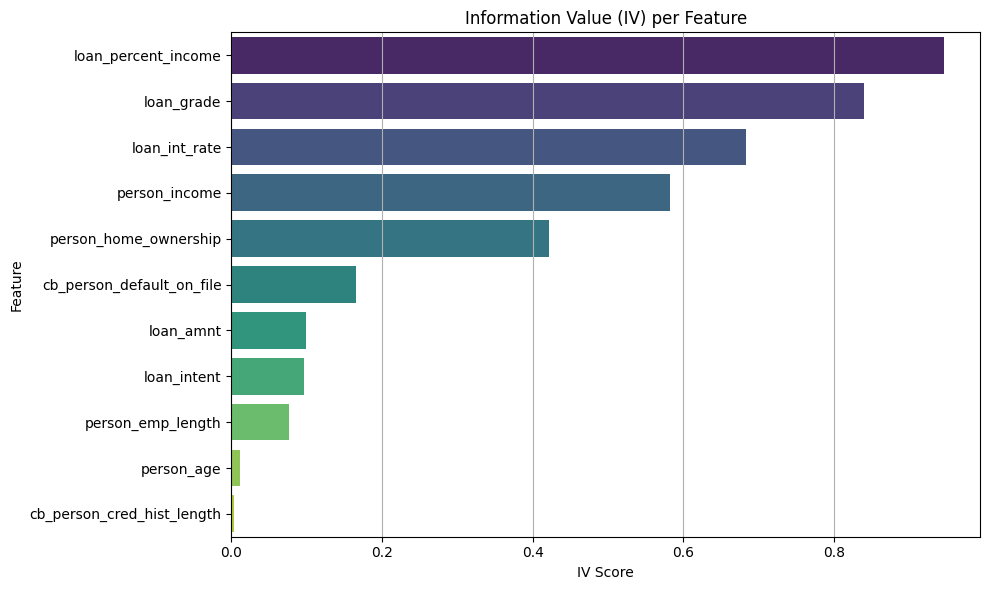

In [17]:
plot_iv(iv_df)

In [18]:
def plot_woe(bp: BinningProcess) -> None:
    """
    Plot WOE charts for each feature.
    Args:
        binning_process (BinningProcess): Fitted binning process.
    """
    for var in bp.get_support(names=True):
        print(f"WOE Plot: {var}")
        #plt.grid(False)
        #bp.get_binned_variable(var).binning_table.plot(metric="woe", show_bin_labels=True)
        binning_table=bp.get_binned_variable(var).binning_table
        binning_table.build()
        binning_table.plot(metric="woe", show_bin_labels=True)
        #plt.grid(False)
        plt.show()

WOE Plot: person_age


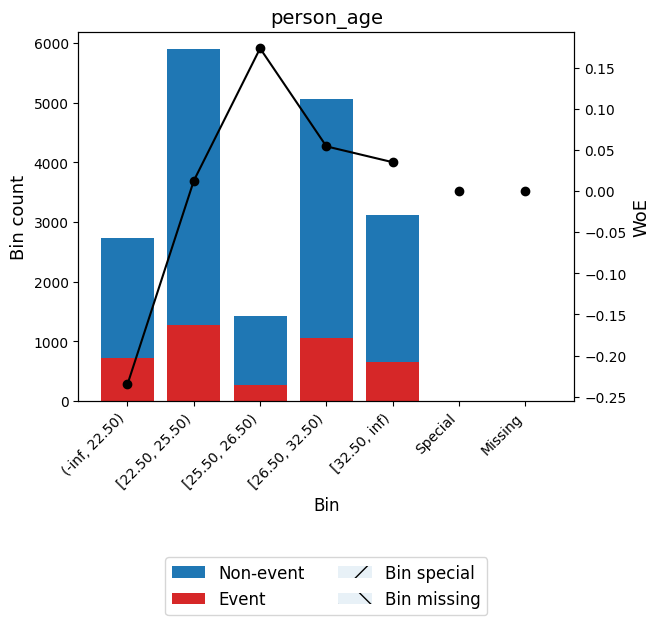

WOE Plot: person_income


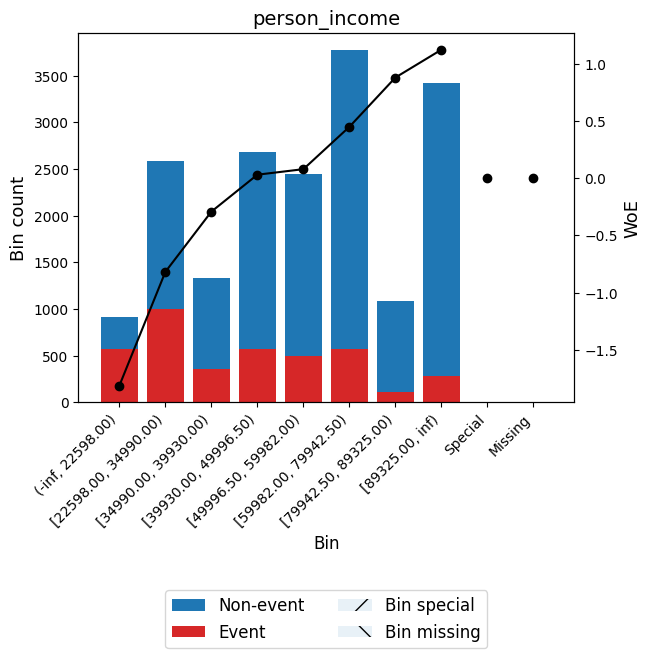

WOE Plot: person_home_ownership


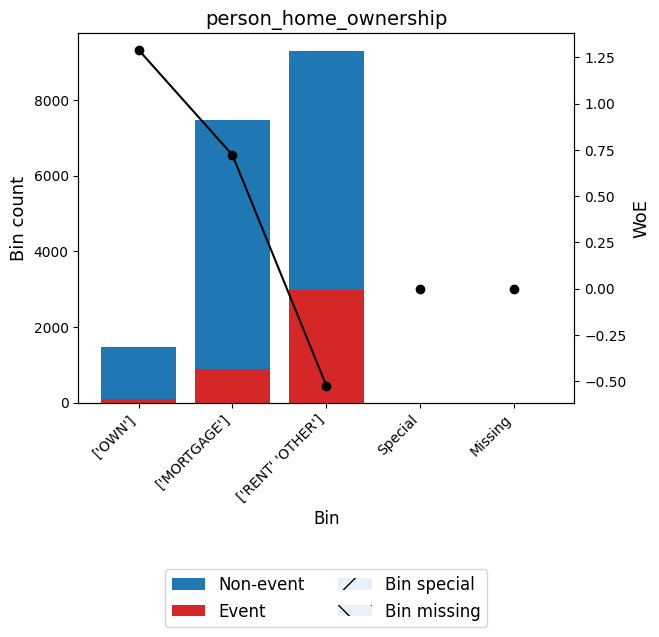

WOE Plot: person_emp_length


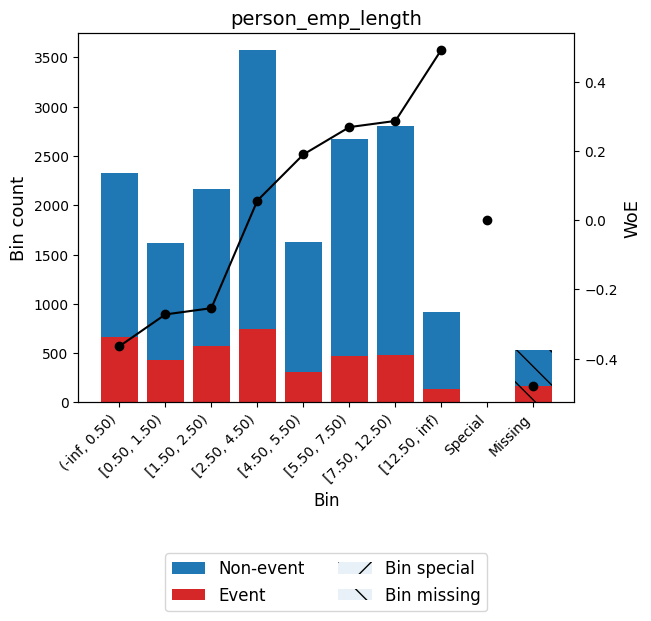

WOE Plot: loan_intent


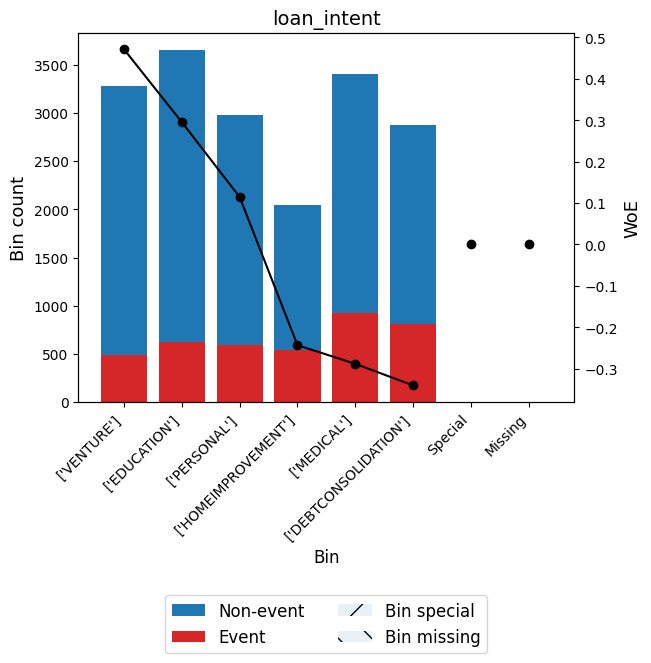

WOE Plot: loan_grade


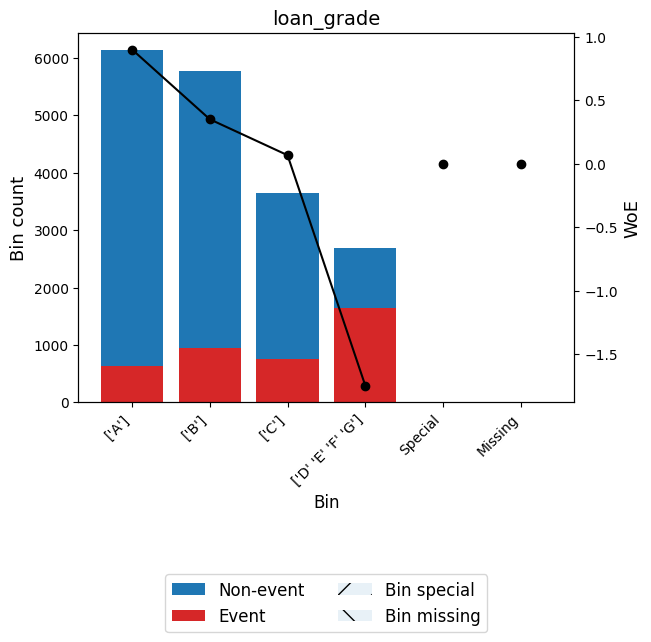

WOE Plot: loan_amnt


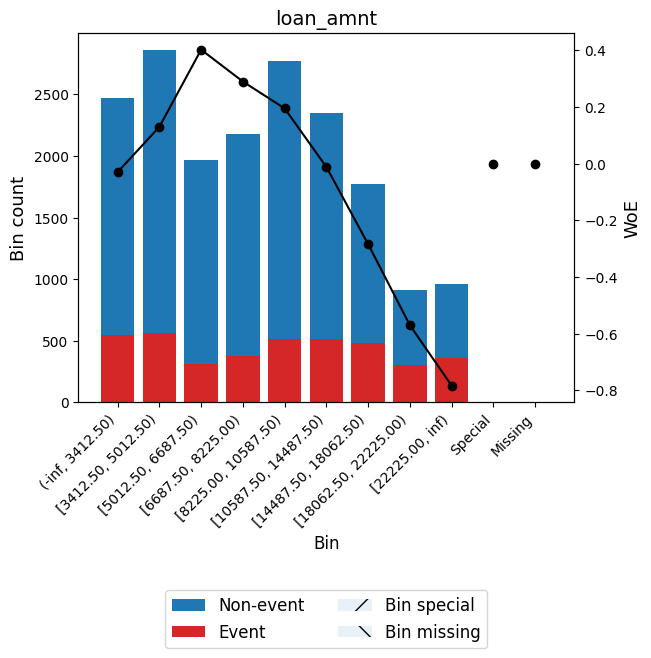

WOE Plot: loan_int_rate


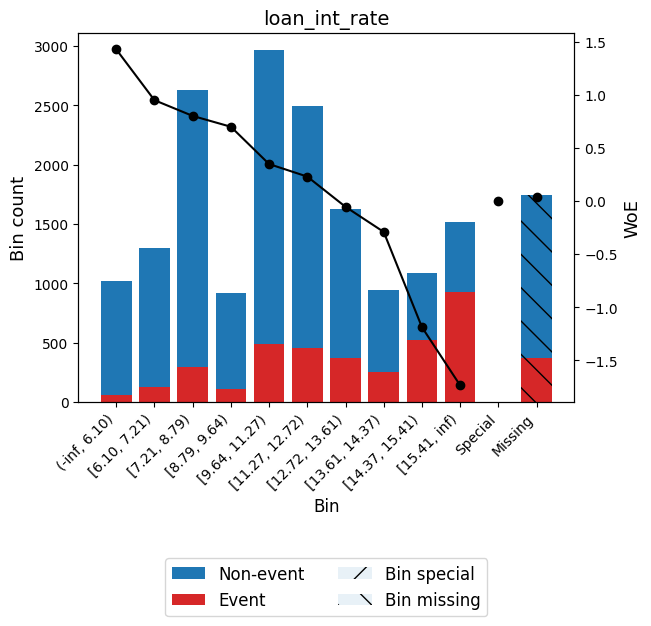

WOE Plot: loan_percent_income


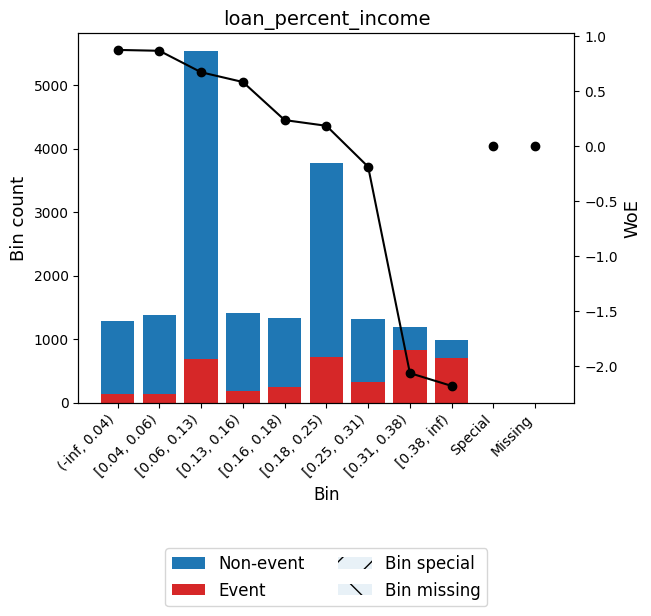

WOE Plot: cb_person_default_on_file


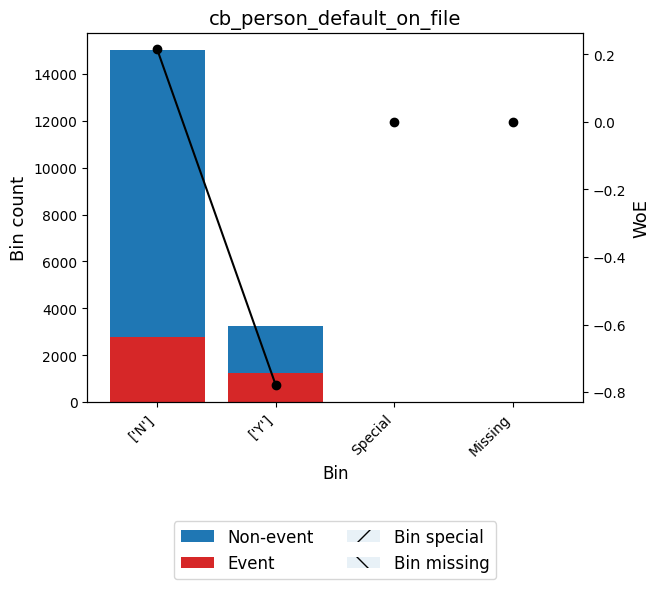

WOE Plot: cb_person_cred_hist_length


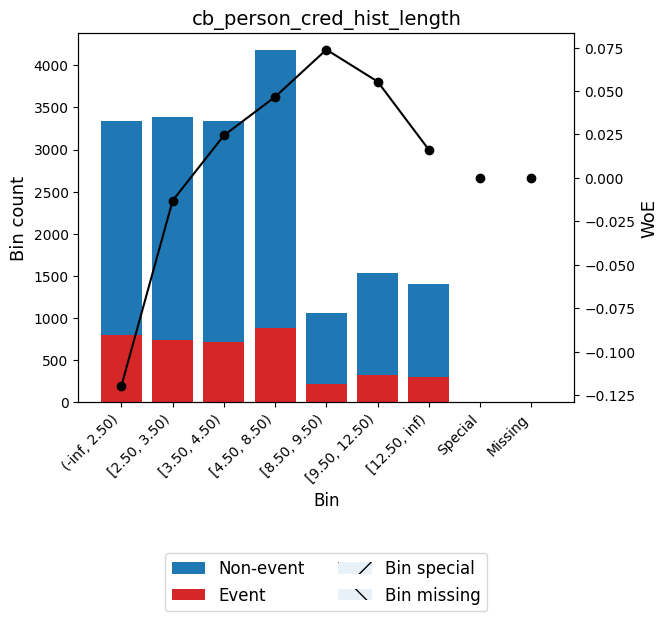

In [19]:
plot_woe(bp)

## ✅ 7. Scorecard Setup

In [20]:
def build_scorecard(bp: BinningProcess, X: pd.DataFrame, y: pd.Series) -> Scorecard:
    """
    Build a scorecard using optbinning and logistic regression.
    Args:
        bp (BinningProcess): Fitted binning process.
        X (pd.DataFrame): Features.
        y (pd.Series): Target.
    Returns:
        Scorecard: Fitted scorecard object.
    """
    try:
        sc = Scorecard(binning_process=bp,
                    #estimator=LogisticRegression(max_iter=1000, class_weight="balanced", solver="lbfgs"),
                    estimator=LogisticRegression(max_iter=1000, solver="lbfgs"),
                    scaling_method="pdo_odds",
                    scaling_method_params={
                        "pdo": 30,
                        "odds": 4,
                        "scorecard_points": 650
                    },
                    intercept_based=True)
        sc.fit(X, y)
        return sc
    except Exception as e:
        raise ValueError(f"Scorecard building failed: {e}")

## 🧾 Scorecard Scaling and Logistic Regression Coefficients


### 🎯 Purpose

In credit risk modeling, we convert model outputs (i.e., predicted probabilities or log-odds from logistic regression) into **credit scores**. This improves interpretability and enables better decision-making through score-based policies.


### 📈 A. Scorecard Formula

The relationship between a customer's credit score and their odds of being good vs. bad is typically defined by a linear equation:

$$
\text{Score} = \text{Offset} - \text{Factor} \cdot \log(\text{Odds})
$$

**Where:**

- $\text{Odds} = \frac{P(\text{Bad})}{P(\text{Good})}$ — Ratio of bad to good outcomes, $P(\text{Bad})$ -> Probability of bad (from model), $P(\text{Good})$-> Probability of good (from model) 
- Logistic regression always models the log-odds of the positive class, in our case (1:default, 0: non-default), i.e., $\log\frac{P(\text{Bad})}{P(\text{Good})}$. 
- $\text{Factor}$ and $\text{Offset}$ — Scaling parameters used to control score range

**NOTE:**

- We subtract the log-odds because we want the score to behave intuitively:

  - Higher probability of **Bad** (i.e., higher risk) → **Lower score**  
  - Lower probability of **Bad** (i.e., safer customer) → **Higher score**

- The minus sign ensures the score **decreases with increasing risk**, which is how a good scorecard should behave.


### ⚙️ B. Scaling Parameters

To make scores interpretable and standardized, we specify two values:

- **PDO** (Points to Double the Odds): Number of points that correspond to doubling the odds
- **Base score and odds**: e.g., Score = 650 at odds = 4 (i.e., 4:1 → 80% good, 20% bad)

Using these inputs, we calculate:

$$
\text{Factor} = \frac{\text{PDO}}{\ln(2)}
$$

$$
\text{Offset} = \text{Score} - \text{Factor} \cdot \ln(\text{Odds})
$$

**Example values:**

- PDO = 30  (Every time the odds double, the score increases by 30 points)
- Odds = 4  (Good:Bad = 4:1)
- Score = 650
- Model log-odds: $\log\frac{P(\text{Bad})}{P(\text{Good})}$

#### Compute Factor

$$
\text{Factor} = \frac{30}{\ln(2)} \approx 43.429
$$

#### Compute Offset

$$
\log\frac{P(\text{Bad})}{P(\text{Good})} = \log\frac{1}{4} = -1.3863
$$

$$
650 = \text{Offset} - 43.429 \times (-1.3863) = \text{Offset} + 60.201
$$

$$
\text{Offset} = 589.799
$$

### 🔢 C. Logistic Regression and Final Score Formula

The logistic regression model gives us:

$$
\ln(\text{Odds}) = \beta_0 + \sum_{i=1}^{n} \beta_i \cdot \text{WOE}_i
$$

**Where:**

- $\beta_0$ — Intercept term  
- $\beta_i$ — Coefficient for the $i$-th predictor  
- $\text{WOE}_i$ — Weight of Evidence for bin $i$


### ✅ Final Score Equation

Substitute the logistic model into the score formula:

$$
\text{Score} = \text{Offset} - \text{Factor} \cdot \left( \beta_0 + \sum_{i=1}^{n} \beta_i \cdot \text{WOE}_i \right)
$$

This shows how scorecards translate logistic regression into a **points-based system**, where each variable/bin contributes additively to the final score.


### 🔍 Per-Attribute Score (Optional Granularity)

To assign a score **per WOE bin (attribute group)**, we use this formula:

$$
\text{Attribute Score}_{ij} = - \left( \beta_i \cdot \text{WOE}_j + \frac{\beta_0}{n} \right) \cdot \text{Factor} + \frac{\text{Offset}}{n}
$$

- This gives the partial score that a particular bin of a variable contributes to the overall score.

**Where:**

- $\text{WOE}_j$ — Weight of Evidence for group $j$ in variable $i$  
- $\beta_i$ — Coefficient for variable $i$  
- $\beta_0$ — Intercept term  
- $n$ — Number of features  
- $\text{Factor}, \text{Offset}$ — Scaling parameters

This allows score contributions to be **broken down by variable and bin**, improving transparency and aligning with traditional scorecard logic.


### 📚 References

- Siddiqi, N. (2006). *Credit Risk Scorecards: Developing and Implementing Intelligent Credit Scoring*. Wiley.  
  [Link to book](https://www.amazon.com/Credit-Risk-Scorecards-Implementing-Intelligent/dp/047175451X)

- Baesens, B. et al. (2009). *Credit Scoring, Response Modeling, and Insurance Rating: A Practical Guide to Forecasting Consumer Behavior*.  
  [Google Books](https://books.google.com/books?id=pWenI8ue_P0C)

In [21]:
# Build scorecard
sc = build_scorecard(bp, X_train, y_train)

In [22]:
# Intercept (float)
print(f"Intercept: {sc.intercept_:.4f}")


# Coefficients (array): shape = (1, n_features) for logistic regression
feature_names = sc.binning_process_.get_support(names=True)
coef_values = sc.estimator_.coef_[0]  # assuming binary classification

df_score_coeff = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coef_values
})
df_score_coeff.round(4)

Intercept: 314.6483


,Feature,Coefficient
0,person_age,-0.3704
1,person_income,-0.8546
2,person_home_ownership,-0.9305
3,person_emp_length,-0.3543
4,loan_intent,-1.5136
5,loan_grade,-1.1706
6,loan_amnt,-0.6116
7,loan_int_rate,-0.1144
8,loan_percent_income,-1.0049
9,cb_person_default_on_file,0.0569


- Most variables reduce the score as their WOE increases — consistent with typical risk behavior.
- `loan_intent` and `loan_grade` have the **strongest negative influence** on score.
- Only one feature (`cb_person_default_on_file`) shows a small **positive** effect.

## 8. Evaluation Metrics

In [23]:
def evaluate(model, X: pd.DataFrame, y: pd.Series, name: str = "Model") -> dict:
    """
    Evaluate a classification model on key metrics (AUC, Gini, KS, Brier Score) and plot curves.
    Args:
        model: Fitted classifier.
        X (pd.DataFrame): Features.
        y (pd.Series): Target.
        name (str): Model name.
    Returns:
        dict: Dictionary of evaluation scores.
    """
    y_proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, y_proba)
    pr_auc = average_precision_score(y, y_proba)
    gini = 2 * auc - 1
    ks = ks_2samp(y_proba[y == 1], y_proba[y == 0]).statistic
    brier = brier_score_loss(y, y_proba)

    print(f"\n{name} Evaluation")
    print(f"AUC: {auc:.2f}, GINI: {gini:.2f}, PR-AUC: {pr_auc:.2f}, KS: {ks:.2f}, Brier: {brier:.2f}")

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0, 1], [0, 1], "k--")
    plt.title(f"ROC Curve: {name}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid()
    plt.show()

    # Calibration Curve
    prob_true, prob_pred = calibration_curve(y, y_proba, n_bins=10)
    plt.figure()
    plt.plot(prob_pred, prob_true, marker="o", label="Logistic Calibration")
    plt.plot([0, 1], [0, 1], "k--", label="Ideal Calibration")
    plt.title(f"Calibration Curve: {name}")
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.grid()
    plt.legend()
    plt.show()
    
    return {"auc": auc, "gini": gini, "pr_auc": pr_auc, "ks": ks, "brier": brier}


Scorecard (Train) Evaluation
AUC: 0.89, GINI: 0.78, PR-AUC: 0.78, KS: 0.64, Brier: 0.09


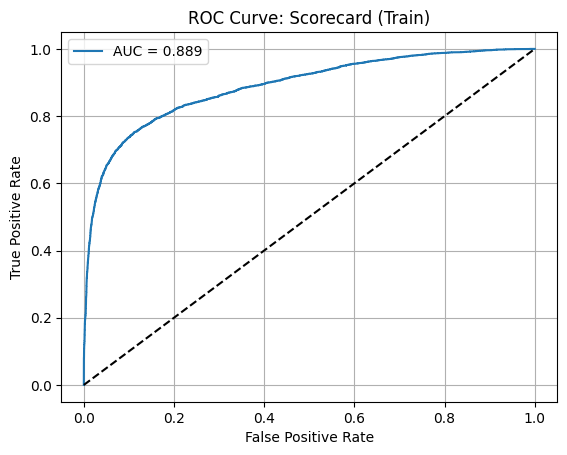

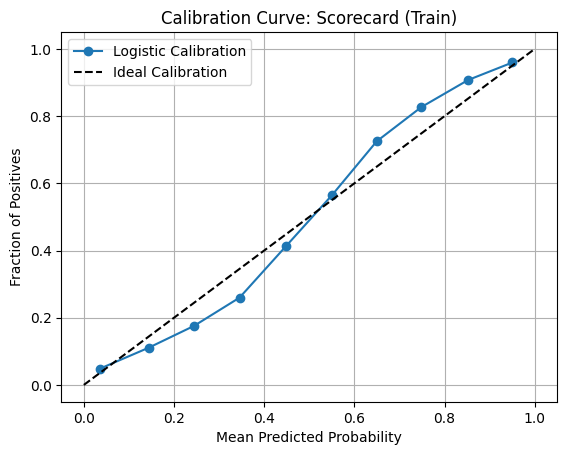


Scorecard (Test) Evaluation
AUC: 0.88, GINI: 0.76, PR-AUC: 0.76, KS: 0.64, Brier: 0.09


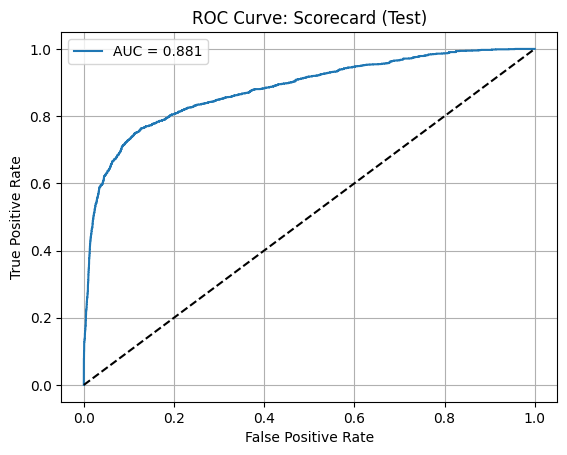

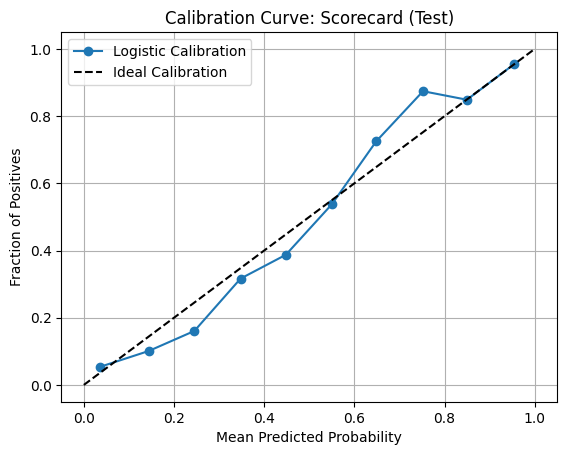


Scorecard (OOT) Evaluation
AUC: 0.88, GINI: 0.76, PR-AUC: 0.76, KS: 0.64, Brier: 0.09


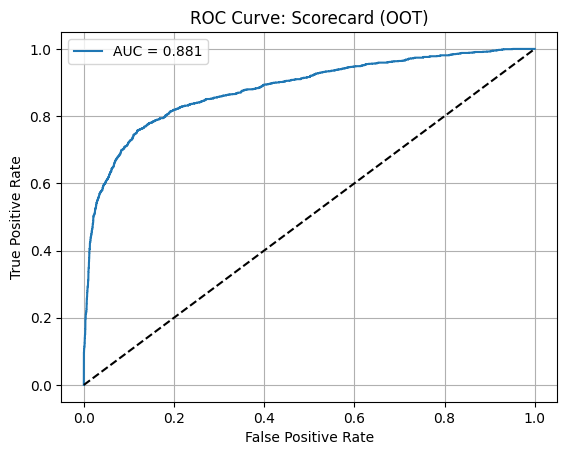

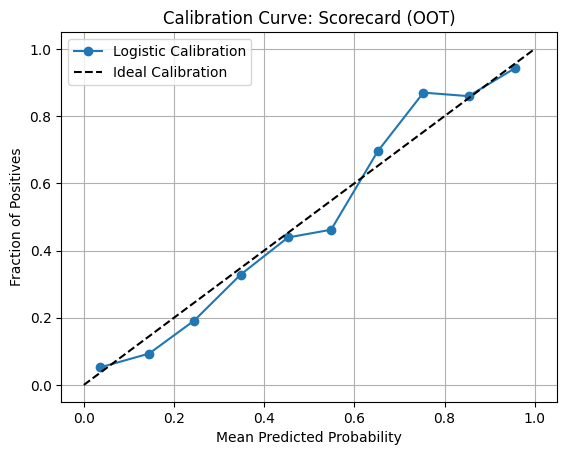

{'auc': 0.8814078224011019,
 'gini': 0.7628156448022039,
 'pr_auc': 0.7602424962634101,
 'ks': np.float64(0.6384438288551281),
 'brier': 0.0947476336539953}

In [24]:
# ===== Scorecard Evaluation =====
evaluate(sc, X_train, y_train, "Scorecard (Train)")
evaluate(sc, X_test, y_test, "Scorecard (Test)")
evaluate(sc, X_oot, y_oot, "Scorecard (OOT)")

## 📈 What a Good Calibration Curve Should Look Like:
Close to the 45° diagonal → probabilities reflect real default rates.

Mild S-shape → common in logistic models; shows slight underconfidence at extremes (e.g., 0.1 and 0.9), which is acceptable.

No steep downward arc or flatness → those indicate overconfidence or poor ranking.

## 🎯 Why Check the Calibration Curve?

Even if your model shows strong performance based on **discrimination metrics** (like AUC, Gini, KS), it doesn't guarantee that the **predicted probabilities are well-calibrated**. Here's why calibration matters:

### 🧠 1. Discrimination vs Calibration

- **Discrimination** tells us how well the model ranks good vs bad outcomes (e.g., default vs non-default).

    - Metrics: **AUC, Gini, KS, PR-AUC**

    - AUC = 0.88? That means the model ranks well, not that the predicted 0.8 actually means an 80% risk of default.

    - **AUC measures ranking ability, not probability accuracy (aka calibration)**.

    - **AUC does NOT tell you how accurate the predicted probabilities are.**

- **Calibration** tells us how closely the predicted probabilities match the **actual observed default rates**.

    - Good calibration means: If the model predicts 100 loans with a 0.2 probability, about 20 of them should actually default.

### 🔍 2. When and Why Calibration Is Important

- In **credit risk** and other high-stakes domains, the actual probability matters — it's used in:

    - Pricing (e.g., interest rates)

    - Risk-based decisioning (e.g., accept/reject thresholds)

    - Regulatory modeling (e.g., PD/LGD modeling)

- A poorly calibrated model may lead to:

    - **Overestimating** risk → losing good customers.

    - **Underestimating** risk → taking on bad debt.

### 🛠️ 3. What If My Model Is Not Well-Calibrated?

- If the calibration curve shows deviation from the ideal diagonal (45°), one can apply **post-processing techniques**:

| Method                        | Description                                                            |
| ----------------------------- | ---------------------------------------------------------------------- |
| **Platt Scaling**             | Fits a logistic regression on the model’s outputs.                     |
| **Isotonic Regression**       | Non-parametric method that fits a piecewise function.                  |
| **Beta Calibration**          | A flexible alternative to Platt for probabilistic outputs.             |
| **Recalibration per segment** | Calibrate separately for different subgroups (e.g., age, income bins). |

One can use `sklearn.calibration.CalibratedClassifierCV` to easily implement Platt or Isotonic scaling.

## Evaluation Summary
| Metric     | Train | Test | OOT  | Interpretation                                |
| ---------- | ----- | ---- | ---- | --------------------------------------------- |
| **AUC**    | 0.89  | 0.88 | 0.88 | Excellent discrimination                      |
| **GINI**   | 0.78  | 0.76 | 0.76 | Very strong (GINI = 2×AUC - 1)                |
| **PR-AUC** | 0.78  | 0.76 | 0.76 | High — especially good for imbalanced classes |
| **KS**     | 0.64  | 0.64 | 0.64 | Excellent (KS > 0.4 is strong)                |
| **Brier**  | 0.09  | 0.09 | 0.09 | Very good calibration (closer to 0 = better)  |

## 🎯 What These Scores Mean
- ✅ AUC/GINI/KS: Your model ranks predictions very well — strong ability to distinguish defaults from non-defaults.

- ✅ PR-AUC: Reflects good precision-recall tradeoff, especially important for imbalanced datasets like credit risk.

- ✅ Brier Score: Low value confirms your predicted probabilities are well calibrated, especially when paired with your improved calibration curve. **Calibration Monitor →** recalibrate if Brier ≥ 0.20

## 🏁 Industry benchmarks:
| Metric | Industry Threshold | My Metric Score |
| ------ | ------------------ | ----------- |
| AUC    | ≥ 0.70             | ✅ 0.88–0.89 |
| KS     | ≥ 0.40             | ✅ 0.64      |
| Brier  | ≤ 0.20             | ✅ 0.09      |
| PR-AUC | High = Good        | ✅ 0.76–0.78 |
| GINI   | ≥ 0.4–0.5          | ✅ 0.76–0.78 |


## 🧮 9. Estimate Population Stability Index (PSI)
Compare PSI between Train vs OOT to detect shifts in feature distributions.

In [25]:
def calculate_psi(expected: np.ndarray, actual: np.ndarray, buckets: int = 10) -> float:
    """
    Calculate Population Stability Index (PSI) between two distributions.
    Args:
        expected (np.ndarray): Expected score or probability (train).
        actual (np.ndarray): Actual score or probability (OOT).
        buckets (int): Number of percentile-based bins to compare.
    Returns:
        float: PSI score.
    """
    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))
    expected_perc = np.histogram(expected, bins=breakpoints)[0] / len(expected)
    actual_perc = np.histogram(actual, bins=breakpoints)[0] / len(actual)

    expected_perc = np.where(expected_perc == 0, 0.0001, expected_perc)
    actual_perc = np.where(actual_perc == 0, 0.0001, actual_perc)

    psi = np.sum((expected_perc - actual_perc) * np.log(expected_perc / actual_perc))
    return float(psi)

In [26]:
psi = calculate_psi(sc.predict_proba(X_train)[:, 1], sc.predict_proba(X_oot)[:, 1])
print(f"PSI: {psi:.4f}")

PSI: 0.0020


- PSI value is low (0.002) and healthy, confirming a very stable model. Set alerts at **PSI ≥ 0.1**.

In [27]:
def evaluate_scorecard_model(model, X: pd.DataFrame, y: pd.Series, dataset_label: str = "train") -> None:
    """
    Evaluate a scorecard model using AUC-ROC, CAP, and KS plots.
    This function generates separate plots for each evaluation metric.
    Args:
        model: Fitted classifier.
        X (pd.DataFrame): Features.
        y (pd.Series): Target (binary).
        dataset_label (str): Label to identify dataset in plot titles (e.g., 'Train', 'Test', 'OOT').
    Returns:
        None
    """
    y_proba = model.predict_proba(X)[:, 1]
    print(f"\n[INFO] Plotting AUC-ROC for {dataset_label} data")
    plt.figure()
    plot_auc_roc(y, y_proba)
    plt.title(f"AUC-ROC Curve ({dataset_label})")
    #plt.grid(True)
    plt.show()

    print(f"[INFO] Plotting Cumulative Accuracy Profile (CAP) for {dataset_label} data")
    plt.figure()
    plot_cap(y, y_proba)
    plt.title(f"CAP Curve ({dataset_label})")
    #plt.grid(True)
    plt.show()

    print(f"[INFO] Plotting Kolmogorov-Smirnov (KS) for {dataset_label} data")
    plt.figure()
    plot_ks(y, y_proba)
    plt.title(f"KS Curve ({dataset_label})")
    #plt.grid(True)
    plt.show()


[INFO] Plotting AUC-ROC for Train data


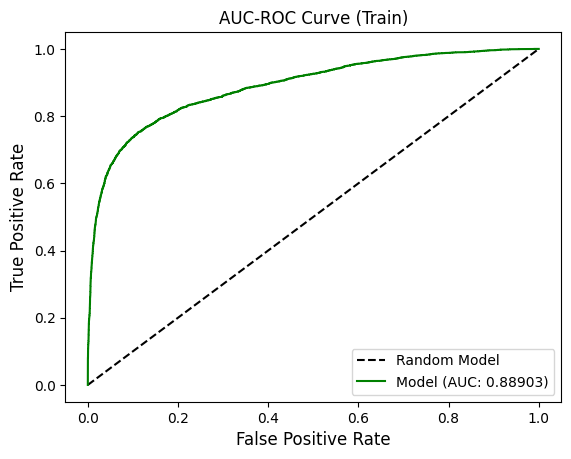

[INFO] Plotting Cumulative Accuracy Profile (CAP) for Train data


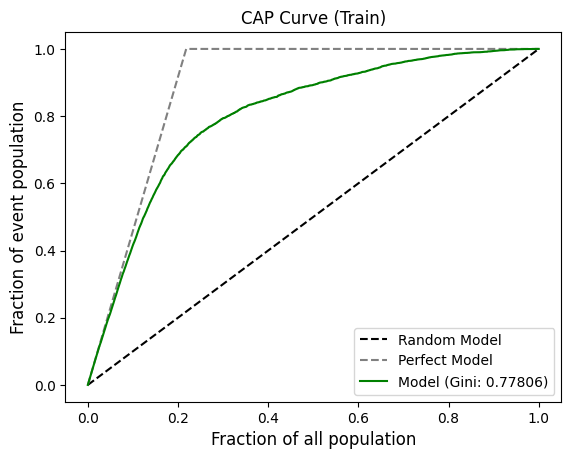

[INFO] Plotting Kolmogorov-Smirnov (KS) for Train data


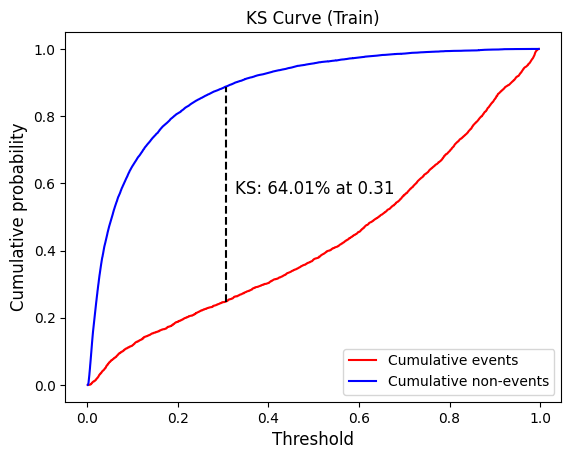


[INFO] Plotting AUC-ROC for Test data


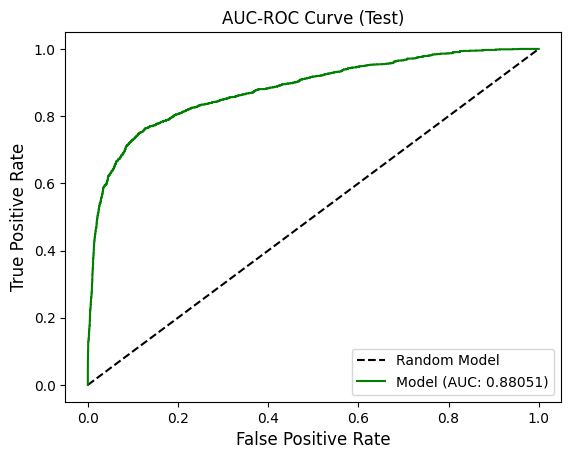

[INFO] Plotting Cumulative Accuracy Profile (CAP) for Test data


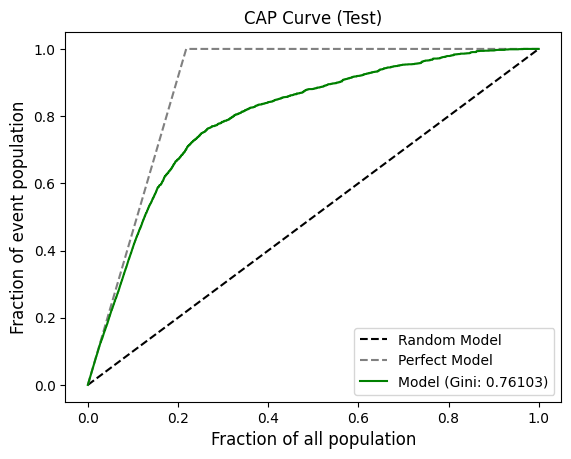

[INFO] Plotting Kolmogorov-Smirnov (KS) for Test data


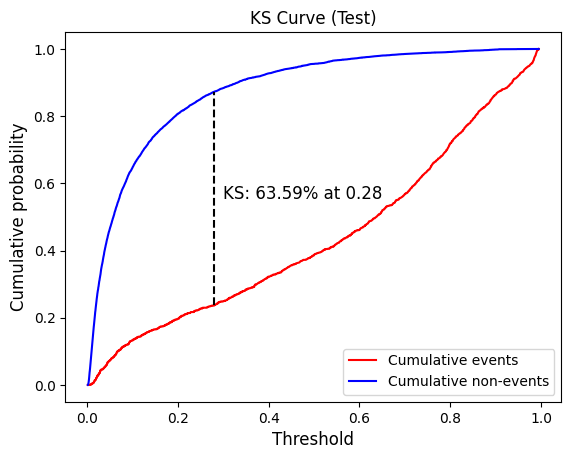


[INFO] Plotting AUC-ROC for OOT data


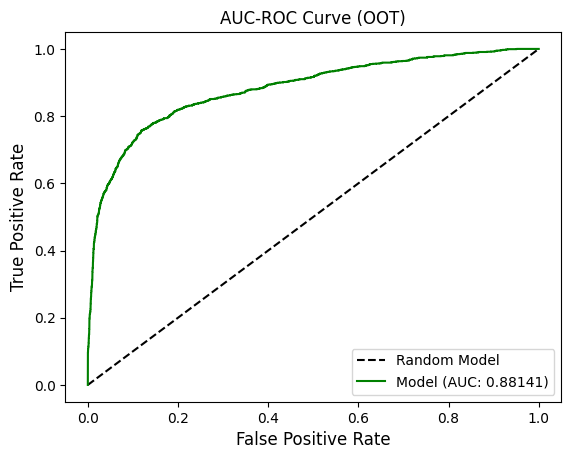

[INFO] Plotting Cumulative Accuracy Profile (CAP) for OOT data


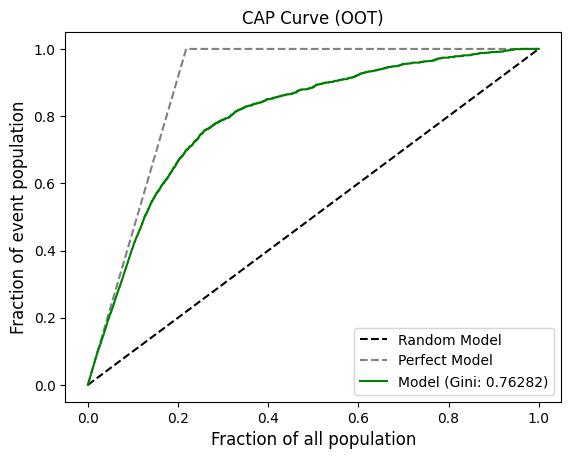

[INFO] Plotting Kolmogorov-Smirnov (KS) for OOT data


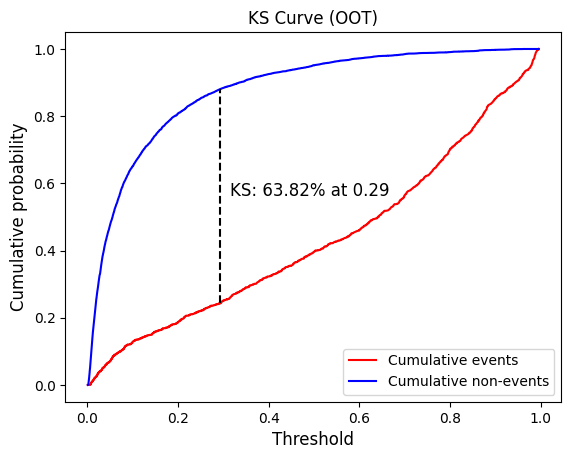

In [28]:
evaluate_scorecard_model(sc, X_train, y_train, "Train")
evaluate_scorecard_model(sc, X_test, y_test, "Test")
evaluate_scorecard_model(sc, X_oot, y_oot, "OOT")

In [29]:
sc.table(style="summary")

,Variable,Bin,Points
0,person_age,"(-inf, 22.50)",0.000000
1,person_age,"[22.50, 25.50)",3.965763
2,person_age,"[25.50, 26.50)",6.544784
3,person_age,"[26.50, 32.50)",4.635656
4,person_age,"[32.50, inf)",4.327289
...,...,...,...
4,cb_person_cred_hist_length,"[8.50, 9.50)",3.281343
5,cb_person_cred_hist_length,"[9.50, 12.50)",2.969289
6,cb_person_cred_hist_length,"[12.50, inf)",2.303176
7,cb_person_cred_hist_length,Special,2.028509


In [30]:
sc.table(style="detailed")

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,person_age,0,"(-inf, 22.50)",2741,0.150241,2026,715,0.260854,-0.234921,0.008836,0.001102,-0.370447,0.000000
1,person_age,1,"[22.50, 25.50)",5897,0.323230,4623,1274,0.216042,0.012425,0.000050,0.000006,-0.370447,3.965763
2,person_age,2,"[25.50, 26.50)",1426,0.078163,1155,271,0.190042,0.173280,0.002232,0.000279,-0.370447,6.544784
3,person_age,3,"[26.50, 32.50)",5061,0.277406,4003,1058,0.209050,0.054207,0.000803,0.000100,-0.370447,4.635656
4,person_age,4,"[32.50, inf)",3119,0.170960,2457,662,0.212248,0.034974,0.000207,0.000026,-0.370447,4.327289
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,cb_person_cred_hist_length,4,"[8.50, 9.50)",1064,0.058321,845,219,0.205827,0.073808,0.000311,0.000039,-0.392189,3.281343
5,cb_person_cred_hist_length,5,"[9.50, 12.50)",1537,0.084247,1216,321,0.208848,0.055424,0.000255,0.000032,-0.392189,2.969289
6,cb_person_cred_hist_length,6,"[12.50, inf)",1402,0.076847,1100,302,0.215407,0.016181,0.000020,0.000003,-0.392189,2.303176
7,cb_person_cred_hist_length,7,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.392189,2.028509


In [31]:
# Get the scorecard table as a DataFrame
scorecard_table = sc.table(style="summary")

# Loop through each unique variable and display its summary
for variable in scorecard_table["Variable"].unique():
    print(f"\n=== Variable: {variable} ===")
    display(scorecard_table[scorecard_table["Variable"] == variable])


=== Variable: person_age ===


,Variable,Bin,Points
0,person_age,"(-inf, 22.50)",0.000000
1,person_age,"[22.50, 25.50)",3.965763
2,person_age,"[25.50, 26.50)",6.544784
3,person_age,"[26.50, 32.50)",4.635656
4,person_age,"[32.50, inf)",4.327289
5,person_age,Special,3.766546
6,person_age,Missing,3.766546



=== Variable: person_income ===


,Variable,Bin,Points
0,person_income,"(-inf, 22598.00)",0.000000
1,person_income,"[22598.00, 34990.00)",36.828026
2,person_income,"[34990.00, 39930.00)",56.319840
3,person_income,"[39930.00, 49996.50)",68.268281
4,person_income,"[49996.50, 59982.00)",70.058788
5,person_income,"[59982.00, 79942.50)",83.766532
6,person_income,"[79942.50, 89325.00)",99.711283
7,person_income,"[89325.00, inf)",108.721471
8,person_income,Special,67.101564
9,person_income,Missing,67.101564



=== Variable: person_home_ownership ===


,Variable,Bin,Points
0,person_home_ownership,[OWN],73.165957
1,person_home_ownership,[MORTGAGE],50.244607
2,person_home_ownership,"[RENT, OTHER]",0.000000
3,person_home_ownership,Special,21.183858
4,person_home_ownership,Missing,21.183858



=== Variable: person_emp_length ===


,Variable,Bin,Points
0,person_emp_length,"(-inf, 0.50)",0.000000
1,person_emp_length,"[0.50, 1.50)",1.411702
2,person_emp_length,"[1.50, 2.50)",1.688237
3,person_emp_length,"[2.50, 4.50)",6.452942
4,person_emp_length,"[4.50, 5.50)",8.493845
5,person_emp_length,"[5.50, 7.50)",9.704544
6,person_emp_length,"[7.50, 12.50)",9.977741
7,person_emp_length,"[12.50, inf)",13.133783
8,person_emp_length,Special,5.582381
9,person_emp_length,Missing,5.582381



=== Variable: loan_intent ===


,Variable,Bin,Points
0,loan_intent,[VENTURE],53.164940
1,loan_intent,[EDUCATION],41.642812
2,loan_intent,[PERSONAL],29.793344
3,loan_intent,[HOMEIMPROVEMENT],6.360085
4,loan_intent,[MEDICAL],3.414122
5,loan_intent,[DEBTCONSOLIDATION],0.000000
6,loan_intent,Special,22.295396
7,loan_intent,Missing,22.295396



=== Variable: loan_grade ===


,Variable,Bin,Points
0,loan_grade,[A],134.075160
1,loan_grade,[B],106.247274
2,loan_grade,[C],91.906644
3,loan_grade,"[D, E, F, G]",0.000000
4,loan_grade,Special,88.497972
5,loan_grade,Missing,88.497972



=== Variable: loan_amnt ===


,Variable,Bin,Points
0,loan_amnt,"(-inf, 3412.50)",19.949223
1,loan_amnt,"[3412.50, 5012.50)",24.178065
2,loan_amnt,"[5012.50, 6687.50)",31.378898
3,loan_amnt,"[6687.50, 8225.00)",28.400335
4,loan_amnt,"[8225.00, 10587.50)",25.893834
5,loan_amnt,"[10587.50, 14487.50)",20.420171
6,loan_amnt,"[14487.50, 18062.50)",13.212026
7,loan_amnt,"[18062.50, 22225.00)",5.643585
8,loan_amnt,"[22225.00, inf)",0.000000
9,loan_amnt,Special,20.734680



=== Variable: loan_int_rate ===


,Variable,Bin,Points
0,loan_int_rate,"(-inf, 6.10)",15.650456
1,loan_int_rate,"[6.10, 7.21)",13.283274
2,loan_int_rate,"[7.21, 8.79)",12.550536
3,loan_int_rate,"[8.79, 9.64)",12.045130
4,loan_int_rate,"[9.64, 11.27)",10.308141
5,loan_int_rate,"[11.27, 12.72)",9.723555
6,loan_int_rate,"[12.72, 13.61)",8.316242
7,loan_int_rate,"[13.61, 14.37)",7.146642
8,loan_int_rate,"[14.37, 15.41)",2.711080
9,loan_int_rate,"[15.41, inf)",0.000000



=== Variable: loan_percent_income ===


,Variable,Bin,Points
0,loan_percent_income,"(-inf, 0.04)",132.736250
1,loan_percent_income,"[0.04, 0.06)",132.395304
2,loan_percent_income,"[0.06, 0.13)",123.906428
3,loan_percent_income,"[0.13, 0.16)",120.057219
4,loan_percent_income,"[0.16, 0.18)",105.016666
5,loan_percent_income,"[0.18, 0.25)",102.759535
6,loan_percent_income,"[0.25, 0.31)",86.556638
7,loan_percent_income,"[0.31, 0.38)",5.061610
8,loan_percent_income,"[0.38, inf)",0.000000
9,loan_percent_income,Special,94.817146



=== Variable: cb_person_default_on_file ===


,Variable,Bin,Points
0,cb_person_default_on_file,[N],0.000000
1,cb_person_default_on_file,[Y],2.449655
2,cb_person_default_on_file,Special,0.529048
3,cb_person_default_on_file,Missing,0.529048



=== Variable: cb_person_cred_hist_length ===


,Variable,Bin,Points
0,cb_person_cred_hist_length,"(-inf, 2.50)",0.000000
1,cb_person_cred_hist_length,"[2.50, 3.50)",1.807380
2,cb_person_cred_hist_length,"[3.50, 4.50)",2.443996
3,cb_person_cred_hist_length,"[4.50, 8.50)",2.820606
4,cb_person_cred_hist_length,"[8.50, 9.50)",3.281343
5,cb_person_cred_hist_length,"[9.50, 12.50)",2.969289
6,cb_person_cred_hist_length,"[12.50, inf)",2.303176
7,cb_person_cred_hist_length,Special,2.028509
8,cb_person_cred_hist_length,Missing,2.028509


In [32]:
train_scores = sc.score(X_train)
test_scores = sc.score(X_test)
oot_scores = sc.score(X_oot)
print(f"Train Score: {train_scores}")
print(f"Test Score: {test_scores}")
print(f"OOT Score: {oot_scores}")

Train Score: [741.96273006 728.39749783 746.93441463 ... 493.44655705 693.92012129
 700.61469994]
Test Score: [691.95071479 701.7245948  771.02509165 ... 722.22920092 624.13133274
 472.75491624]
OOT Score: [695.46112858 717.18862358 782.01446401 ... 704.36979738 672.9983709
 742.94303213]


In [33]:
train_scores.shape, test_scores.shape, oot_scores.shape

((18244,), (7820,), (6517,))

In [34]:
# Compute min and max
train_min_score = np.min(train_scores)
train_max_score = np.max(train_scores)

test_min_score = np.min(test_scores)
test_max_score = np.max(test_scores)

oot_min_score = np.min(oot_scores)
oot_max_score = np.max(oot_scores)

print(f"Train Score Range: Min = {train_min_score:.2f}, Max = {train_max_score:.2f}")
print(f"Test Score Range: Min = {test_min_score:.2f}, Max = {test_max_score:.2f}")
print(f"OOT Score Range: Min = {oot_min_score:.2f}, Max = {oot_max_score:.2f}")

Train Score Range: Min = 341.64, Max = 876.05
Test Score Range: Min = 361.30, Max = 871.03
OOT Score Range: Min = 352.69, Max = 876.21


In [35]:
def plot_dual_score_distribution(scores, y, title="Score Distribution", bins=20, figsize=(12, 5)):
    """
    Plot side-by-side histograms:
    - Left: overall score distribution
    - Right: score distribution by event vs non-event
    
    Parameters
    ----------
    scores : array-like
        Score values predicted by the model.
        
    y : array-like
        True binary labels (0 = Good, 1 = Bad).
        
    title : str, optional
        Plot title (default is "Score Distribution").
        
    bins : int, optional
        Number of bins (default is 50).
        
    figsize : tuple, optional
        Figure size (default is (12, 5)).
    
    Returns
    -------
    None
    """
    # Ensure inputs are numpy arrays
    scores = np.array(scores)
    y = np.array(y)

    # Masks
    mask_good = y == 0
    mask_bad = y == 1

    # Setup subplots
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Left: Overall score distribution
    axes[0].hist(scores, bins=bins, color=custom_palette[2], alpha=0.7, edgecolor="black")
    axes[0].set_title("Overall Score Distribution")
    axes[0].set_xlabel("Credit Score")
    axes[0].set_ylabel("Frequency")
    axes[0].grid(True, linestyle='--', alpha=0.4)

    # Right: Segregated by event vs non-event
    axes[1].hist(scores[mask_good], bins=bins, label="Good Customer", color=custom_palette[0], alpha=0.7)
    axes[1].hist(scores[mask_bad], bins=bins, label="Bad Customer", color=custom_palette[1], alpha=0.7)
    axes[1].set_title("Score Distribution by Class")
    axes[1].set_xlabel("Credit Score")
    axes[1].legend()
    axes[1].grid(True, linestyle='--', alpha=0.4)

    # Main title
    fig.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

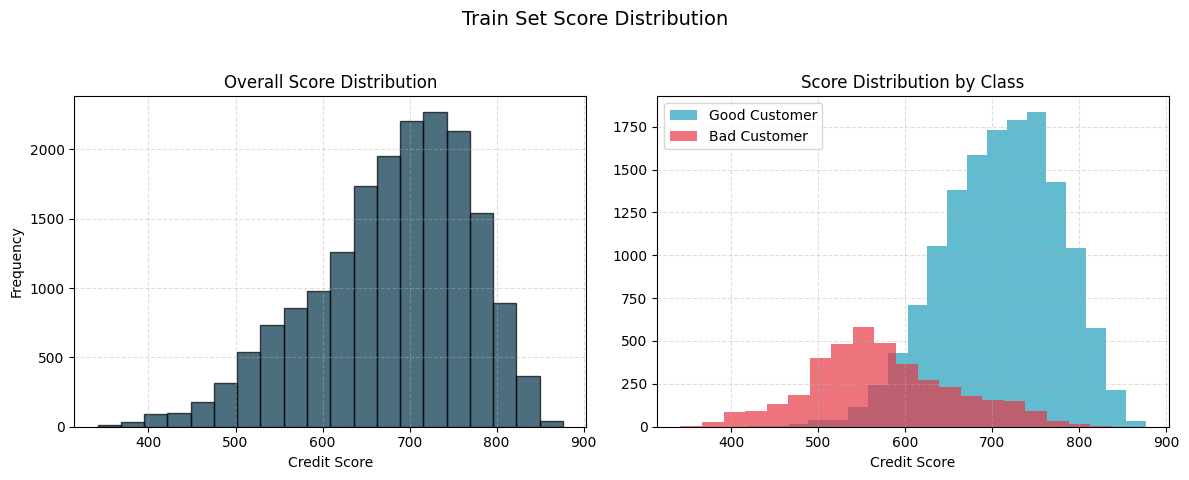

In [36]:
plot_dual_score_distribution(train_scores, y_train, title="Train Set Score Distribution")

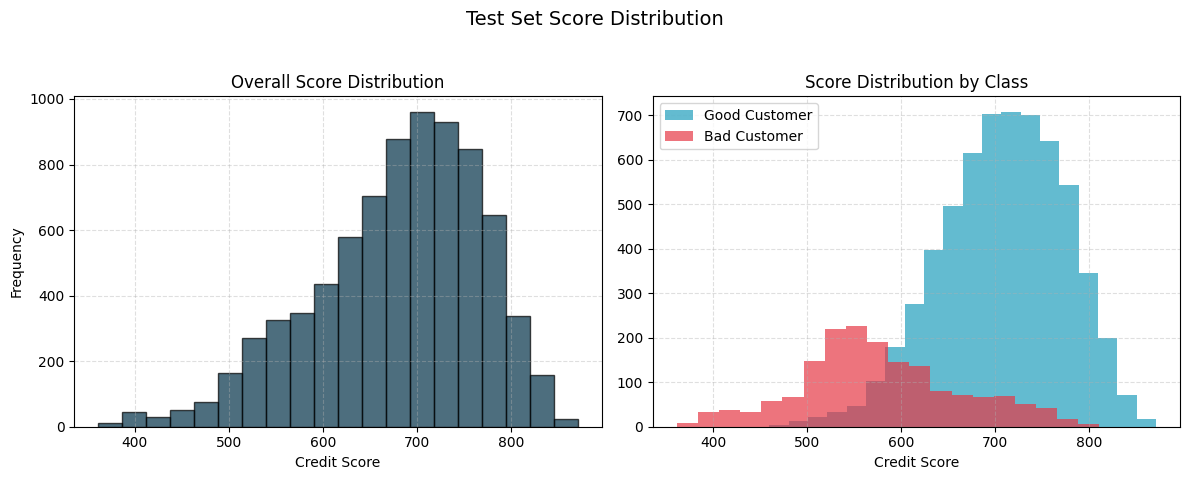

In [37]:
plot_dual_score_distribution(test_scores, y_test, title="Test Set Score Distribution")

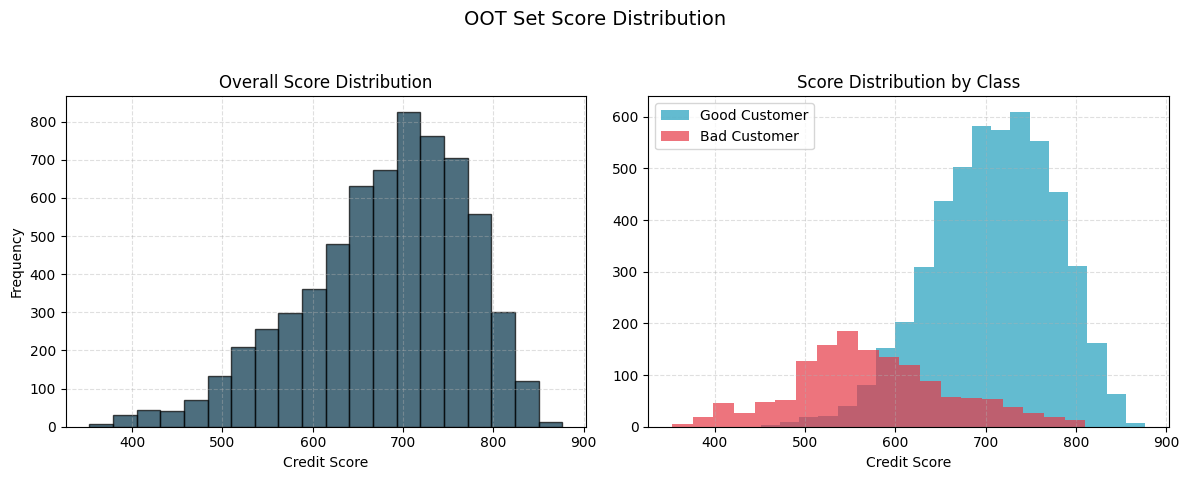

In [38]:
plot_dual_score_distribution(oot_scores, y_oot, title="OOT Set Score Distribution")

### 📌 Interpretation

#### 🔹 Left Panel: Overall Score Distribution

- Shows the **distribution of credit scores** for the full dataset (both good and bad customers).
- Helps identify whether the model produces:
  - A **wide range** of scores (good score differentiation), or
  - A **narrow/clustered** score range (less separation power)

#### 🔸 Right Panel: Score Distribution by Class

- **Overlap between classes (right plot)**:
  - Some overlap is expected, but **less overlap = better model**.
- **Distribution width**:
  - A **wide score spread** allows for more granular decision thresholds.
- If **bad customers are scoring high**, the model may be misclassifying risk — review features or binning.


In [39]:
# Just to confirm what’s inside
score_table = sc.table(style="summary")
print(score_table.columns)
display(score_table.head())


Index(['Variable', 'Bin', 'Points'], dtype='object')


,Variable,Bin,Points
0,person_age,"(-inf, 22.50)",0.000000
1,person_age,"[22.50, 25.50)",3.965763
2,person_age,"[25.50, 26.50)",6.544784
3,person_age,"[26.50, 32.50)",4.635656
4,person_age,"[32.50, inf)",4.327289


In [40]:
sc.binning_process_.transform(X_train, metric="bins")

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
19626,"[32.50, inf)","[34990.00, 39930.00)",['MORTGAGE'],Missing,['EDUCATION'],['B'],"[3412.50, 5012.50)","[8.79, 9.64)","[0.06, 0.13)",['N'],"[4.50, 8.50)"
21635,"[26.50, 32.50)","[49996.50, 59982.00)",['MORTGAGE'],"[7.50, 12.50)",['DEBTCONSOLIDATION'],['A'],"[8225.00, 10587.50)","[6.10, 7.21)","[0.18, 0.25)",['N'],"[4.50, 8.50)"
27794,"[32.50, inf)","[89325.00, inf)",['MORTGAGE'],"[12.50, inf)",['DEBTCONSOLIDATION'],['C'],"[10587.50, 14487.50)","[12.72, 13.61)","[0.04, 0.06)",['N'],"[4.50, 8.50)"
6245,"(-inf, 22.50)","[22598.00, 34990.00)",['RENT' 'OTHER'],"[1.50, 2.50)",['PERSONAL'],['B'],"[5012.50, 6687.50)","[11.27, 12.72)","[0.18, 0.25)",['N'],"[3.50, 4.50)"
10088,"[22.50, 25.50)","[22598.00, 34990.00)",['RENT' 'OTHER'],"[0.50, 1.50)",['VENTURE'],['C'],"[8225.00, 10587.50)",Missing,"[0.25, 0.31)",['N'],"[2.50, 3.50)"
...,...,...,...,...,...,...,...,...,...,...,...
13963,"(-inf, 22.50)","[59982.00, 79942.50)",['RENT' 'OTHER'],"[5.50, 7.50)",['VENTURE'],['A'],"[10587.50, 14487.50)","[7.21, 8.79)","[0.18, 0.25)",['N'],"(-inf, 2.50)"
20130,"[26.50, 32.50)","[22598.00, 34990.00)",['RENT' 'OTHER'],"[0.50, 1.50)",['VENTURE'],['C'],"[3412.50, 5012.50)","[13.61, 14.37)","[0.13, 0.16)",['N'],"[9.50, 12.50)"
4424,"[22.50, 25.50)","[22598.00, 34990.00)",['RENT' 'OTHER'],"(-inf, 0.50)",['HOMEIMPROVEMENT'],['D' 'E' 'F' 'G'],"[3412.50, 5012.50)","[15.41, inf)","[0.16, 0.18)",['Y'],"(-inf, 2.50)"
27142,"[26.50, 32.50)","[89325.00, inf)",['MORTGAGE'],"[2.50, 4.50)",['MEDICAL'],['C'],"[22225.00, inf)","[12.72, 13.61)","[0.18, 0.25)",['N'],"[4.50, 8.50)"


In [41]:
def predict_pd(model, X_input: pd.DataFrame) -> pd.DataFrame:
    """
    Predict Probability of Default (PD) using a fitted scorecard model.
    
    This function handles both full datasets and single-row predictions.
    
    Args:
        model: Fitted scorecard model (optbinning.Scorecard).
        X_input (pd.DataFrame): Input features (can be one row or full dataset).
    
    Returns:
        pd.DataFrame: Original input + predicted PD as a new column.
    """
    # Ensure input is a DataFrame
    if isinstance(X_input, pd.Series):
        X_input = X_input.to_frame().T
    elif isinstance(X_input, dict):
        X_input = pd.DataFrame([X_input])

    if not isinstance(X_input, pd.DataFrame):
        raise TypeError("Input must be a pandas DataFrame, Series, or dictionary representing a row.")
    
    # Predict probabilities (PD = probability of being class '1')
    pd_probs = model.predict_proba(X_input)[:, 1]
    
    # Return original data with predicted PD column
    result = X_input.copy()
    result["Predicted_PD"] = pd_probs
    
    return result

In [42]:
train_pd = predict_pd(sc, X_train)
test_pd = predict_pd(sc, X_test)
oot_pd = predict_pd(sc, X_oot)


In [43]:
display(train_pd.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,Predicted_PD
19626,35,35000,MORTGAGE,NaN,EDUCATION,B,4000,9.63,0.11,N,8,0.028998
21635,30,50000,MORTGAGE,8.0,DEBTCONSOLIDATION,A,10000,6.62,0.20,N,7,0.039254
27794,34,220000,MORTGAGE,13.0,DEBTCONSOLIDATION,C,11275,12.99,0.05,N,8,0.025933
6245,22,30000,RENT,2.0,PERSONAL,B,6000,12.42,0.20,N,4,0.258931
10088,23,34000,RENT,1.0,VENTURE,C,9500,NaN,0.28,N,3,0.309309


In [44]:
display(test_pd.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,Predicted_PD
3990,23,39996,OWN,1.0,MEDICAL,B,11000,9.63,0.28,N,3,0.086625
20865,28,44000,MORTGAGE,12.0,MEDICAL,B,8000,10.59,0.18,N,6,0.070346
16220,24,156000,MORTGAGE,8.0,PERSONAL,B,15000,10.25,0.10,N,2,0.015030
17586,21,14400,RENT,6.0,EDUCATION,C,4750,12.73,0.34,Y,2,0.893574
24696,31,75000,MORTGAGE,3.0,EDUCATION,B,12000,10.38,0.16,N,10,0.026275


In [45]:
display(oot_pd.head())

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,Predicted_PD
6616,22,50000,RENT,6.0,PERSONAL,B,6000,11.89,0.12,N,2,0.080419
21802,32,52000,RENT,0.0,PERSONAL,A,7125,7.49,0.14,N,10,0.050274
31886,37,205000,MORTGAGE,3.0,EDUCATION,B,18000,10.39,0.09,N,14,0.011699
17799,26,100000,MORTGAGE,5.0,DEBTCONSOLIDATION,B,24000,10.99,0.24,N,4,0.058299
5207,23,44340,OWN,0.0,VENTURE,C,3000,12.98,0.07,Y,3,0.018640


In [72]:
def generate_credit_score_report(
    model, X: pd.DataFrame, y: pd.Series, dataset_name: str = "Test"
) -> pd.DataFrame:
    """
    Generate a credit score band report (segmented) for regulators or stakeholders.
    
    Binning logic: (lower_bound, score] across all bins.
    
    Args:
        model: Trained scorecard model from optbinning.
        X (pd.DataFrame): Feature set.
        y (pd.Series): Target values (0 = Good, 1 = Bad).
        dataset_name (str): Label for output report.
    
    Returns:
        pd.DataFrame: Aggregated credit risk report by score levels.
    """
    try:
        # ==== 1. Scoring ====
        scores = model.score(X).round()

        # ==== 2. Define credit score bin edges and labels ====
        #bins = [-np.inf, 350, 410, 470, 530, 590, 650, 710, 770, 830, np.inf] # 10 levels
        bins = [-np.inf, 380, 450, 520, 590, 660, 730, 800, np.inf] # 10 levels, 70 step size
        n_labels = 8
        labels = range(1, n_labels+1)

        # Credit level descriptions
        credit_descriptions = {
            1: "Very Poor",
            2: "Poor",
            3: "Average",
            4: "Above Average",
            5: "Good",
            6: "Very Good",
            7: "Excellent",
            8: "Exceptional"
        }


        # ==== 3. Assign credit level using right-inclusive logic (lower < score <= upper) ====
        credit_levels = pd.cut(scores, bins=bins, labels=labels, include_lowest=False).astype(int)

        # ==== 4. Create dataframe with labels ====
        df = pd.DataFrame({
            "Score": scores,
            "Target": y.values,
            "Credit Level": credit_levels
        })

        # ==== 5. Handle unbinned scores (shouldn't occur, but safe)
        n_dropped = df["Credit Level"].isna().sum()
        if n_dropped > 0:
            print(f"⚠️ {n_dropped} scores did not fall into any credit bin.")

        # ==== 6. Group and aggregate ====
        grouped = df.groupby("Credit Level", observed=True).agg(
            Customers=("Target", "count"),
            Bad_Customers=("Target", "sum"),
            Good_Customers=("Target", lambda x: (x == 0).sum())
        ).reset_index()

        # Add bin edges and descriptions
        grouped["Credit Lower Bound"] = [bins[i] for i in range(len(bins) - 1)]
        grouped["Credit Upper Bound"] = [bins[i + 1] for i in range(len(bins) - 1)]
        grouped["Credit Description"] = grouped["Credit Level"].map(credit_descriptions)

        # ==== 7. Percentages ====
        total_customers = len(df)
        total_good = (df["Target"] == 0).sum()
        total_bad = (df["Target"] == 1).sum()

        grouped["Customer Rate (%)"] = 100 * grouped["Customers"] / total_customers
        grouped["Default Rate (%)"] = 100 * grouped["Bad_Customers"] / grouped["Customers"]

        # ==== 8. Cumulative metrics (starting from best (Level 8) to worst (Level 1)) ====
        grouped = grouped.sort_values("Credit Level", ascending=False).reset_index(drop=True)

        grouped["Good Customers Coverage (%)"] = 100 * grouped["Good_Customers"].cumsum() / total_good
        grouped["Loss Coverage (%)"] = 100 * grouped["Bad_Customers"].cumsum() / total_bad

        # ==== 9. Select & rename columns ====
        report = grouped[
            [
                "Credit Level", "Credit Lower Bound", "Credit Upper Bound", "Credit Description",
                "Customers", "Customer Rate (%)",
                "Good_Customers", "Bad_Customers", "Default Rate (%)",
                "Good Customers Coverage (%)", "Loss Coverage (%)"
            ]
        ]

        report.columns = [
            "Credit Level", "Credit Lower Bound", "Credit Upper Bound", "Credit Description",
            "Customers", "Customer Rate (%)",
            "Good Customers", "Bad Customers", "Default Rate (%)",
            "Good Customers Coverage (%)", "Loss Coverage (%)"
        ]

        report = report.round(2)

        print(f"\n✅ Credit Score Report generated for: {dataset_name}")
        return report

    except Exception as e:
        print(f"\n❌ Failed to generate credit score report for {dataset_name}: {e}")
        return pd.DataFrame()  # return empty DF on failure

## 📄 Credit Score Report: Column Descriptions
| **Column Name**               | **Description**                                                                 |
| ----------------------------- | ------------------------------------------------------------------------------- |
| `Credit Level`                | Discrete score band label (1 = Worst, 8 = Best), used for segmenting customers. |
| `Credit Lower Bound`          | The **exclusive lower bound** of the credit score range for the level.          |
| `Credit Upper Bound`          | The **inclusive upper bound** of the credit score range for the level.          |
| `Credit Description`          | Qualitative label for interpretability (e.g., "Poor", "Excellent").             |
| `Customers`                   | Total number of customers in that score band.                                   |
| `Customer Rate (%)`           | Percentage of total customers in that level.                                    |
| `Good Customers`              | Number of customers with **target = 0** (i.e., **no default**).                 |
| `Bad Customers`               | Number of customers with **target = 1** (i.e., **defaulted**).                  |
| `Default Rate (%)`            | Bad Customers ÷ Total Customers × 100 — i.e., the **riskiness** of the level.   |
| `Good Customers Coverage (%)` | Cumulative % of all good customers **captured from top (Level 8 → 1)**.         |
| `Loss Coverage (%)`           | Cumulative % of all bad customers **captured from top (Level 8 → 1)**.          |

## 🔍 Key Columns and Their Significance
### 🎯 Default Rate (%)
- **Why it matters:** Indicates how risky each score band is.

- Used to set **cut-off thresholds** — bands with high default rates may be rejected or require higher pricing.

### 🎯 Good Customers Coverage (%)
- **Why it matters:** Shows how much of your **performing (good)** population you’re retaining.

- High coverage means you're approving a large share of the good book.

### 🎯 Loss Coverage (%)
- **Why it matters:** Indicates how much of the **bad book (defaults)** you're allowing into the approved pool.

- Lower is better — means you're excluding risky profiles effectively.

## 📊 Decision Use Case: Trade-off Between Good and Bad
- By comparing **Good Customers Coverage vs. Loss Coverage**, you can choose a **score cut-off** that:

    - Maximizes retention of good customers

    - Minimizes exposure to losses


In [73]:
# For Test set
credit_report_test = generate_credit_score_report(sc, X_test, y_test, dataset_name="Test")
display(credit_report_test)


✅ Credit Score Report generated for: Test


,Credit Level,Credit Lower Bound,Credit Upper Bound,Credit Description,Customers,Customer Rate (%),Good Customers,Bad Customers,Default Rate (%),Good Customers Coverage (%),Loss Coverage (%)
0,8,800.0,inf,Exceptional,416,5.32,414,2,0.48,6.77,0.12
1,7,730.0,800.0,Excellent,2073,26.51,1987,86,4.15,39.27,5.16
2,6,660.0,730.0,Very Good,2471,31.60,2262,209,8.46,76.27,17.41
3,5,590.0,660.0,Good,1536,19.64,1178,358,23.31,95.53,38.39
4,4,520.0,590.0,Above Average,888,11.36,235,653,73.54,99.38,76.67
5,3,450.0,520.0,Average,324,4.14,38,286,88.27,100.00,93.43
6,2,380.0,450.0,Poor,105,1.34,0,105,100.00,100.00,99.59
7,1,-inf,380.0,Very Poor,7,0.09,0,7,100.00,100.00,100.00


In [74]:
# For Train set
credit_report_train = generate_credit_score_report(sc, X_train, y_train, dataset_name="Train")
display(credit_report_train)


✅ Credit Score Report generated for: Train


,Credit Level,Credit Lower Bound,Credit Upper Bound,Credit Description,Customers,Customer Rate (%),Good Customers,Bad Customers,Default Rate (%),Good Customers Coverage (%),Loss Coverage (%)
0,8,800.0,inf,Exceptional,1090,5.97,1083,7,0.64,7.59,0.18
1,7,730.0,800.0,Excellent,4937,27.06,4760,177,3.59,40.96,4.62
2,6,660.0,730.0,Very Good,5536,30.34,5067,469,8.47,76.49,16.41
3,5,590.0,660.0,Good,3551,19.46,2733,818,23.04,95.65,36.96
4,4,520.0,590.0,Above Average,2032,11.14,550,1482,72.93,99.50,74.20
5,3,450.0,520.0,Average,847,4.64,69,778,91.85,99.99,93.74
6,2,380.0,450.0,Poor,233,1.28,2,231,99.14,100.00,99.55
7,1,-inf,380.0,Very Poor,18,0.10,0,18,100.00,100.00,100.00


In [75]:
# For OOT set
credit_report_oot = generate_credit_score_report(sc, X_oot, y_oot, dataset_name="OOT")
display(credit_report_oot)


✅ Credit Score Report generated for: OOT


,Credit Level,Credit Lower Bound,Credit Upper Bound,Credit Description,Customers,Customer Rate (%),Good Customers,Bad Customers,Default Rate (%),Good Customers Coverage (%),Loss Coverage (%)
0,8,800.0,inf,Exceptional,392,6.02,388,4,1.02,7.62,0.28
1,7,730.0,800.0,Excellent,1756,26.94,1684,72,4.10,40.67,5.34
2,6,660.0,730.0,Very Good,1979,30.37,1820,159,8.03,76.39,16.53
3,5,590.0,660.0,Good,1276,19.58,952,324,25.39,95.07,39.31
4,4,520.0,590.0,Above Average,709,10.88,215,494,69.68,99.29,74.05
5,3,450.0,520.0,Average,300,4.60,36,264,88.00,100.00,92.62
6,2,380.0,450.0,Poor,98,1.50,0,98,100.00,100.00,99.51
7,1,-inf,380.0,Very Poor,7,0.11,0,7,100.00,100.00,100.00


In [76]:
def plot_credit_score_coverage(
    report: pd.DataFrame,
    dataset_name: str = "Test",
    cutoff_level: int = 5,  # Example: Accept customers with level ≥ 5
):
    """
    Plot Good vs. Loss Coverage by Credit Level, with shading and cut-off indicator.

    Args:
        report (pd.DataFrame): Output from generate_credit_score_report.
        dataset_name (str): Title for the plot.
        cutoff_level (int): Cut-off credit level. Customers with levels ≥ cutoff are accepted.
    """
    try:
        # Sort for plotting from best to worst (8 to 1)
        plot_df = report.sort_values("Credit Level", ascending=False)

        # Extract values
        credit_levels = plot_df["Credit Level"]
        good_coverage = plot_df["Good Customers Coverage (%)"]
        loss_coverage = plot_df["Loss Coverage (%)"]

        # Initialize plot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Plot coverage lines
        ax.plot(credit_levels, good_coverage, marker='o', label="Good Customers Coverage (%)", color="green")
        ax.plot(credit_levels, loss_coverage, marker='o', label="Loss Coverage (%)", color="red")

        # Invert x-axis: Level 8 (best) on left
        ax.invert_xaxis()

        # Cut-off shading
        ax.axvspan(cutoff_level, max(credit_levels), color="green", alpha=0.05, label="Accept Zone")
        ax.axvspan(min(credit_levels), cutoff_level - 0.01, color="red", alpha=0.05, label="Reject Zone")

        # Cut-off vertical line
        ax.axvline(cutoff_level, color="blue", linestyle="--", linewidth=2, label=f"Cut-off: Level {cutoff_level}")

        # Styling
        ax.set_title(f"Good vs. Loss Coverage by Credit Score Level\n{dataset_name}")
        ax.set_xlabel("Credit Level (Higher = Better)")
        ax.set_ylabel("Cumulative Coverage (%)")
        ax.set_xticks(credit_levels)
        ax.grid(True, linestyle='--', alpha=0.6)
        ax.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"\n❌ Failed to plot credit score coverage for {dataset_name}: {e}")

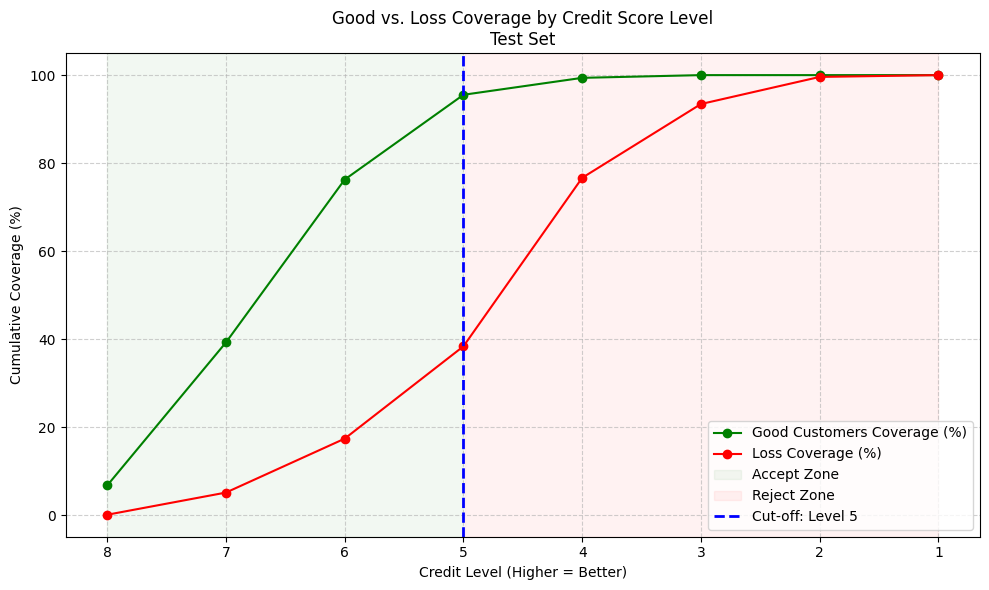

In [77]:
plot_credit_score_coverage(credit_report_test, dataset_name="Test Set", cutoff_level=5)

## Cumulative Metrics (Descending: Level 8 → 1)
Cumulative metrics such as:

- Good Customers Coverage (%)

- Loss Coverage (%)

are calculated **from the best credit score bands downward** because this mirrors how **real-world credit decisioning** is made.

So we want to know:

- **How much of the good population have we captured so far?**

- **How much of the bad (loss) population are we also accepting?**

So if you set your cutoff at Level ≥ 5, you’re:

Keeping **95.5% of good customers**

Accepting **38.4% of the losses**

That’s a decision-making **sweet spot** — high approval, moderate risk.



In [80]:
sns.set_style("whitegrid")

def plot_customers_by_level(report: pd.DataFrame):
    """Bar plot of number of customers per credit level."""
    try:
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Credit Level", y="Customers", data=report, palette="Blues_d")
        plt.title("Number of Customers by Credit Level")
        plt.xlabel("Credit Level (8 = Best)")
        plt.ylabel("Number of Customers")
        plt.gca().invert_xaxis()  # Optional: level 8 → 1
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"❌ Failed to plot customers by level: {e}")

def plot_default_rate_by_level(report: pd.DataFrame):
    """Bar plot of default rate by credit level."""
    try:
        plt.figure(figsize=(10, 6))
        sns.barplot(x="Credit Level", y="Default Rate (%)", data=report, palette="Reds")
        plt.title("Default Rate by Credit Level")
        plt.xlabel("Credit Level (8 = Best)")
        plt.ylabel("Default Rate (%)")
        plt.gca().invert_xaxis()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"❌ Failed to plot default rate by level: {e}")


def plot_good_vs_bad_stacked(report: pd.DataFrame):
    """Stacked bar chart of good vs bad customers per level."""
    try:
        plt.figure(figsize=(10, 6))
        bar_width = 0.6
        levels = report["Credit Level"]
        good = report["Good Customers"]
        bad = report["Bad Customers"]

        plt.bar(levels, good, label="Good", color="green")
        plt.bar(levels, bad, bottom=good, label="Bad", color="red")
        plt.xlabel("Credit Level (8 = Best)")
        plt.ylabel("Customer Count")
        plt.title("Good vs Bad Customers by Credit Level")
        plt.legend()
        plt.gca().invert_xaxis()
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"❌ Failed to plot good vs bad stacked bar: {e}")

def plot_customer_distribution_pie(report: pd.DataFrame):
    """Pie chart of customer distribution across credit levels."""
    try:
        plt.figure(figsize=(8, 8))
        plt.pie(
            report["Customers"],
            labels=[f"Level {lvl}" for lvl in report["Credit Level"]],
            autopct='%1.1f%%',
            startangle=140,
            colors=sns.color_palette("pastel")
        )
        plt.title("Customer Distribution by Credit Level")
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"❌ Failed to plot customer distribution pie: {e}")

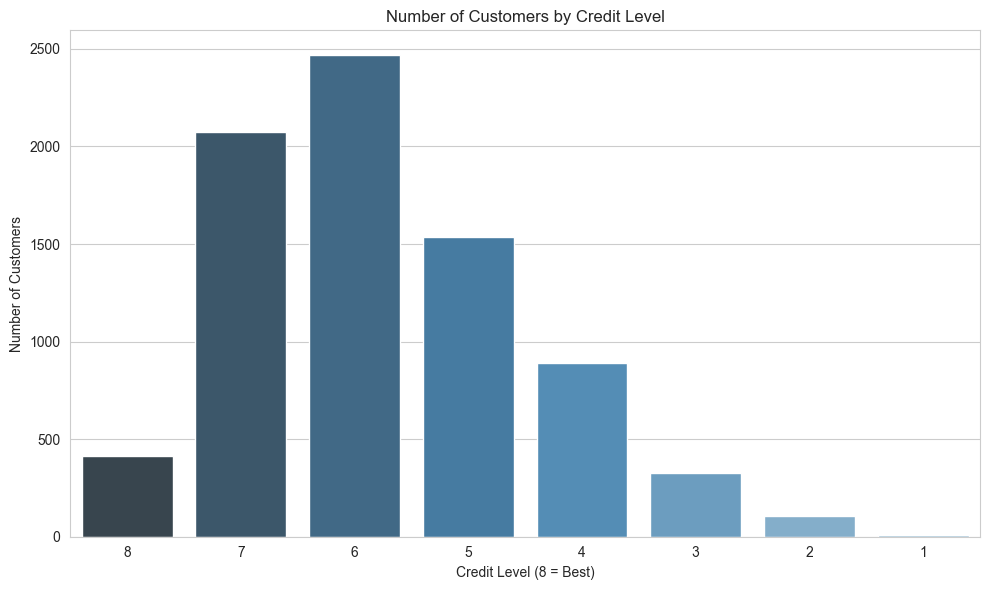

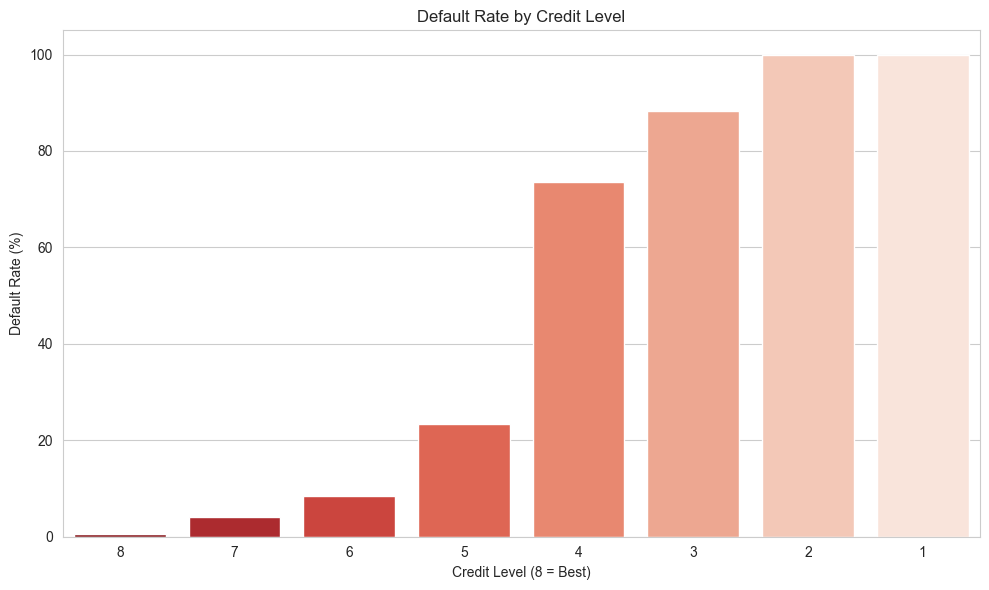

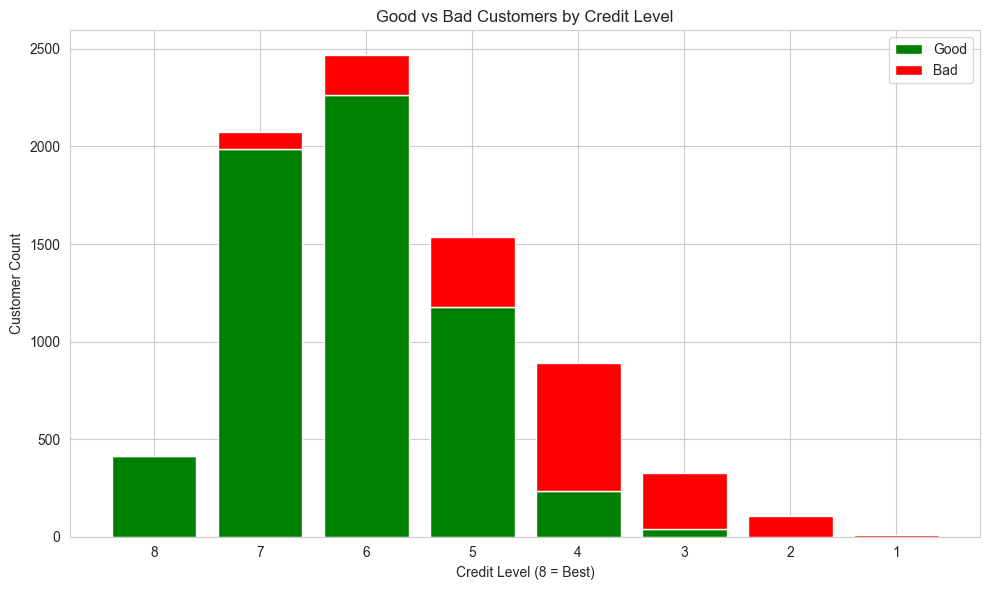

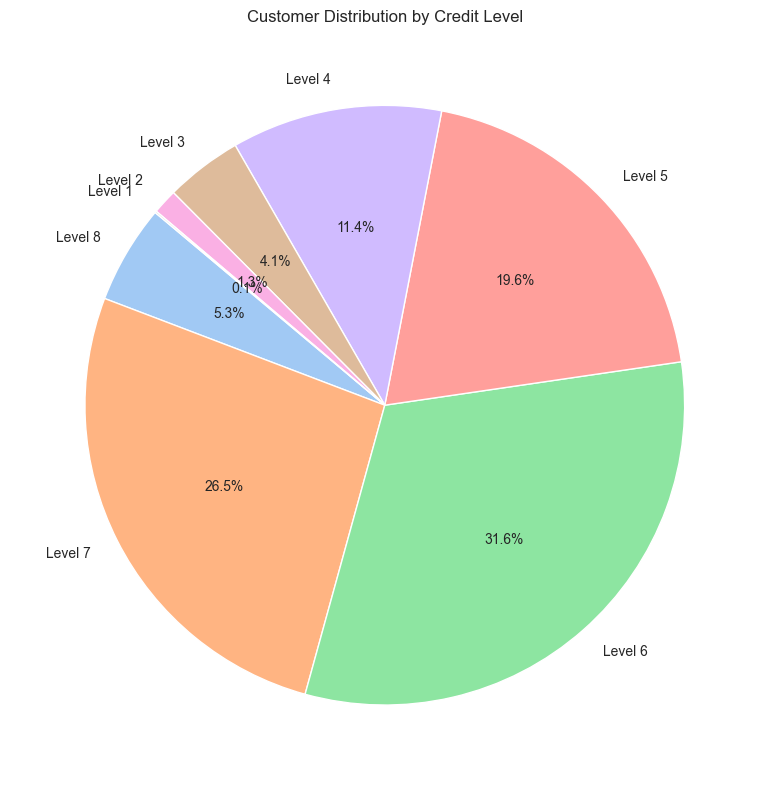

In [81]:
# Plotting various visualizations for the credit report
plot_customers_by_level(credit_report_test)
plot_default_rate_by_level(credit_report_test)
plot_good_vs_bad_stacked(credit_report_test)
plot_customer_distribution_pie(credit_report_test)

## 📈 Credit Score Report – Visual Insights (Test Set)

---

### Customers by Credit Level

- Majority of customers are in **Level 6 ("Very Good")** and **Level 7 ("Excellent")**, totaling over **58%**.
- **Very few customers** are found in Levels 1–3 (bottom bands), indicating the model concentrates risk in lower levels.
- The population distribution suggests most applicants are low-risk, as expected in real-world lending data.


### Default Rate by Credit Level

- Strong **monotonic increase** in default rate as credit level decreases:
  - Level 8: **0.48%**
  - Level 4: **73.54%**
  - Level 1–2: **100%**
- This confirms the model **ranks risk effectively** — a key requirement for regulatory compliance and operational decisioning.


### Good vs Bad Customers (Stacked Bars)

- **Levels 8 to 6** are heavily dominated by good customers.
- **Sharp rise in bad customers** from Level 5 downwards:
  - Level 4 has **653 bad vs. 235 good**
  - Level 3: **286 bad vs. 38 good**
  - Levels 2–1: **all bad**
- This makes it easy to define **cut-off policies**:
  - Accept: Level ≥ 5
  - Review: Level 4
  - Decline: Level < 4


### Customer Distribution (Pie Chart)

- Largest groups:
  - **Level 6 (31.6%)**
  - **Level 7 (26.5%)**
- Only **~5.5%** of customers lie in Levels 1–3.
- Suggests that riskier applicants are few, and the scorecard provides clear stratification for decision-making.


## Overall Scorecard Behavior (Test Set)

- Scorecard shows:
  - **Strong separation** between good and bad customers. This separation makes it possible to use the score to make real-world decisions like who to approve, who to reject, or who needs more scrutiny
  - **Consistent rank-ordering** of risk. As the credit level decreases (from Level 8 → Level 1), the default rate increases smoothly and logically. This is crucial for business trust, regulatory validation, and pricing models
  - **Minimal overlap** across credit bands. In each score band (e.g., Level 6, 5, 4...), one class is dominant — either mostly good or mostly bad. There aren’t too many bands with a 50/50 mix, which would indicate confusion or ambiguity in the model’s predictions. This gives confident decision thresholds — one can say "Everyone in Level ≤ 3 is too risky" without hesitation.
- Enables clear business actions like:
  - Setting **cut-offs**
  - Understanding **risk exposure per segment**

